<a href="https://colab.research.google.com/github/yenngoc1809/edm-student-prediction/blob/main/Fairness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from imblearn.over_sampling import SMOTE
%pip install optuna
%pip install aif360


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 8.9 MB/s eta 0:00:00


In [ ]:
%pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 7.0 MB/s eta 0:00:00


In [ ]:
file_path = "/content/data_encoded.csv"
data = pd.read_csv(file_path)

## **split data and balance**

In [ ]:
X = data.drop(columns=['Academic_Performance']) # Independent variables
y = data['Academic_Performance']  # Target variable


# Split data first (to avoid leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Print class distribution before balancing
print("Class distribution before SMOTE:")
print(y_train.value_counts())


# # Apply SMOTE to balance classes
# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

from imblearn.combine import SMOTETomek

# Apply SMOTETomek to balance classes and clean overlaps
smote = SMOTETomek(sampling_strategy=1.0, random_state=42, n_jobs=-1)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print class distribution after balancing
print("\nClass distribution after SMOTE:")
print(y_train_balanced.value_counts())

Class distribution before SMOTE:
Academic_Performance
1    702
0     94
Name: count, dtype: int64

Class distribution after SMOTE:
Academic_Performance
1    698
0    698
Name: count, dtype: int64


In [ ]:
%pip install dice-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.3 MB/s eta 0:00:00


# LightBGM

Generate Python code to train and evaluate a LightGBM model for classification, including hyperparameter tuning with Optuna, and visualize the results.

## Import libraries

### Subtask:
Import necessary libraries for LightGBM, Optuna, data splitting, and evaluation.


**Reasoning**:
Import the necessary libraries for LightGBM, Optuna, data splitting, and evaluation as instructed.



In [ ]:
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

## Define objective function

### Subtask:
Create an Optuna objective function for LightGBM to optimize hyperparameters based on validation accuracy.


**Reasoning**:
Define the Optuna objective function for LightGBM hyperparameter tuning.



In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold # Import StratifiedKFold
from sklearn.metrics import f1_score

SEED = 42

def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "random_state": SEED,
        "n_jobs": -1,
        "verbose": -1,
        "is_unbalance": True
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    f1_scores = []

    for train_idx, val_idx in cv.split(X_train_balanced, y_train_balanced):
        # Dùng iloc vì X_train_balanced và y_train_balanced là DataFrame/Series
        X_tr, X_val = X_train_balanced.iloc[train_idx], X_train_balanced.iloc[val_idx]
        y_tr, y_val = y_train_balanced.iloc[train_idx], y_train_balanced.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_tr, y_tr)

        y_val_pred = model.predict(X_val)
        f1_scores.append(f1_score(y_val, y_val_pred, pos_label=0))

    return np.mean(f1_scores)

# Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best parameters:", study.best_params)
print(f"Best F1(class 0): {study.best_value:.4f}")

[I 2025-10-01 07:32:29,428] A new study created in memory with name: no-name-65bf6611-de61-4ac7-88dd-ec9f940560ed
[I 2025-10-01 07:32:30,052] Trial 0 finished with value: 0.9319388581444784 and parameters: {'n_estimators': 495, 'learning_rate': 0.034352004159334044, 'max_depth': 7, 'subsample': 0.9534818600555076, 'colsample_bytree': 0.7641245546749117, 'lambda_l1': 2.2679256352926562, 'lambda_l2': 0.00040735155003937496}. Best is trial 0 with value: 0.9319388581444784.
[I 2025-10-01 07:32:30,827] Trial 1 finished with value: 0.9204468673687816 and parameters: {'n_estimators': 822, 'learning_rate': 0.14888471687029653, 'max_depth': 3, 'subsample': 0.7389659075487232, 'colsample_bytree': 0.8205626906813188, 'lambda_l1': 2.2332214247524855e-08, 'lambda_l2': 0.00015588434097560576}. Best is trial 0 with value: 0.9319388581444784.
[I 2025-10-01 07:32:31,722] Trial 2 finished with value: 0.9286878178691016 and parameters: {'n_estimators': 735, 'learning_rate': 0.021192788094196943, 'max_dep

Best parameters: {'n_estimators': 189, 'learning_rate': 0.03089728127090027, 'max_depth': 7, 'subsample': 0.7842953941800553, 'colsample_bytree': 0.5562197846800215, 'lambda_l1': 6.462416899074111e-06, 'lambda_l2': 0.0020947227825040015}
Best F1(class 0): 0.9375


**Reasoning**:
Import the necessary libraries for LightGBM, Optuna, data splitting, and evaluation as instructed.

**Reasoning**:
Define the Optuna objective function for LightGBM hyperparameter tuning.

## Run Optuna Study

### Subtask:
Execute the Optuna study to find the best hyperparameters for the LightGBM model.

**Reasoning**:
Execute the Optuna study to find the best hyperparameters for the LightGBM model using the defined objective function.

In [ ]:
SEED = 42
study_lgbm = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
study_lgbm.optimize(objective, n_trials=30, show_progress_bar=True)

print("Best parameters for LightGBM:", study_lgbm.best_params)
print(f"Best validation accuracy for LightGBM: {study_lgbm.best_value:.4f}")

[I 2025-10-01 07:32:49,712] A new study created in memory with name: no-name-64e3c6b6-1ee2-42b5-8b9d-95e20f1f485f


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-01 07:32:50,293] Trial 0 finished with value: 0.9297676665922296 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'lambda_l1': 2.5348407664333426e-07, 'lambda_l2': 3.3323645788192616e-08}. Best is trial 0 with value: 0.9297676665922296.
[I 2025-10-01 07:32:51,030] Trial 1 finished with value: 0.932289688851697 and parameters: {'n_estimators': 880, 'learning_rate': 0.07725378389307355, 'max_depth': 8, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07}. Best is trial 1 with value: 0.932289688851697.
[I 2025-10-01 07:32:52,289] Trial 2 finished with value: 0.9342457794605308 and parameters: {'n_estimators': 263, 'learning_rate': 0.018659959624904916, 'max_depth': 5, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'lambda_l1': 4.17890272377219e-06, 'la

## Train Final Model and Evaluate

### Subtask:
Train the LightGBM model on the full balanced training data using the best hyperparameters and evaluate it on the test set.

**Reasoning**:
Train the final LightGBM model using the best hyperparameters found by Optuna and evaluate its performance on the test set, providing accuracy, confusion matrix, classification report, and ROC-AUC.


LightGBM Test Accuracy: 0.9000

LightGBM Confusion Matrix:
 [[ 13  10]
 [ 10 167]]

LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.57      0.57        23
           1       0.94      0.94      0.94       177

    accuracy                           0.90       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.90      0.90      0.90       200


LightGBM Test ROC–AUC: 0.8035


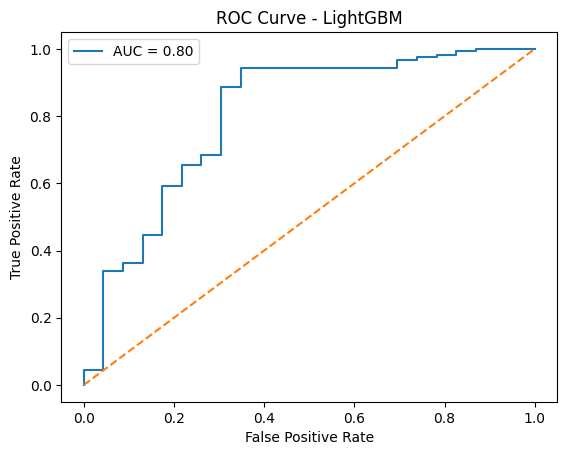

['lgbm_model.pkl']

In [ ]:
# Train final model on full balanced train split using best params
best_params_lgbm = study_lgbm.best_params
# Ensure is_unbalance is included in the final model parameters
best_params_lgbm["is_unbalance"] = True

final_model_lgbm = lgb.LGBMClassifier(**best_params_lgbm)
final_model_lgbm.fit(X_train_balanced, y_train_balanced)

# Predict on test set
y_pred_lgbm = final_model_lgbm.predict(X_test)

# Evaluate
print(f"\nLightGBM Test Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print("\nLightGBM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print("\nLightGBM Classification Report:\n", classification_report(y_test, y_pred_lgbm))

# ROC–AUC
y_prob_lgbm = final_model_lgbm.predict_proba(X_test)[:, 1]
auc_lgbm = roc_auc_score(y_test, y_prob_lgbm)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_prob_lgbm)
print(f"\nLightGBM Test ROC–AUC: {auc_lgbm:.4f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr_lgbm, tpr_lgbm, label=f'AUC = {auc_lgbm:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve - LightGBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
import os, json, joblib
from pathlib import Path

joblib.dump(final_model_lgbm, "lgbm_model.pkl")

In [ ]:
%pip install aif360
%pip install 'aif360[inFairness]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.0 MB/s eta 0:00:00


## Evaluate Fairness

## aif360

In [ ]:
# ================== Imports ==================
import optuna
import lightgbm as lgb
import numpy as np
import pandas as pd

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import StandardDataset


# ================== Config ==================
SEED = 42
np.random.seed(SEED)
SENSITIVE_COL = "Gender"   # tên cột nhạy cảm
POS_LABEL = 1              # nhãn thuận lợi (positive class)
N_TRIALS = 80              # số trial Optuna


# ================== Helper utils ==================
def tpr_score(y_true, y_pred):
    # Recall lớp POS_LABEL
    return recall_score(y_true, y_pred, pos_label=POS_LABEL, zero_division=0)

def fpr_score(y_true, y_pred):
    # FPR = FP / (FP + TN) với 0 là negative
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    denom = (fp + tn)
    return float(fp / denom) if denom > 0 else 0.0

def selection_rate_metric(y_true, y_pred):
    return float(np.mean(y_pred))

def gap(series):
    return float(series.max() - series.min())

def pct_reduction(before, after):
    if before is None or np.isnan(before) or before <= 0:
        return 0.0
    return 100.0 * (before - after) / before

def print_by_group(title, mf: MetricFrame):
    print(f"\n=== {title} ===")
    df = mf.by_group.copy()
    print("By-group metrics:")
    print(df.to_string(float_format=lambda x: f"{x:0.4f}"))
    print("\nGaps (max - min):")
    for col in df.columns:
        print(f"  {col:<20s}: {gap(df[col]):0.4f}")

def ensure_binary_sensitive(X_train, X_test, col):
    vals = pd.unique(X_train[col])
    if len(vals) != 2:
        raise ValueError(f"SENSITIVE_COL '{col}' phải có đúng 2 giá trị. Thấy: {vals}")
    # map sang 0/1 nếu chưa
    if set(pd.Series(vals).astype(str)) != set(["0", "1"]):
        v0, v1 = list(vals)
        mapping = {v0: 0, v1: 1}
        X_train = X_train.copy()
        X_test = X_test.copy()
        X_train[col] = X_train[col].map(mapping)
        X_test[col]  = X_test[col].map(mapping)
    return X_train, X_test

def find_privileged_value(X_train, y_train, sens_col, pos_label=1):
    # nhóm có mean(y) cao hơn là privileged
    g = pd.DataFrame({sens_col: X_train[sens_col], "y": y_train}).groupby(sens_col)["y"].mean()
    if np.isclose(g.loc[0], g.loc[1]):
        return 1.0
    return float(g.idxmax())


# ================== Chuẩn hóa dữ liệu nhạy cảm, tạo biến train/test drop SENSITIVE_COL ==================
X_train, X_test = ensure_binary_sensitive(X_train, X_test, SENSITIVE_COL)
sens_col = SENSITIVE_COL
Xtr = X_train.drop(columns=[sens_col])   # dùng cho fit/predict
Xte = X_test.drop(columns=[sens_col])    # dùng cho predict
sensi_tr = X_train[sens_col].values
sensi_te = X_test[sens_col].values

PRIV_VAL = find_privileged_value(X_train, y_train, SENSITIVE_COL, POS_LABEL)
FAV = float(POS_LABEL)


# ================== Dựng AIF360 StandardDataset (khớp POS_LABEL & privileged) ==================
train_df_aif = pd.concat([X_train, y_train.rename('Academic_Performance')], axis=1)

train_aif = StandardDataset(
    train_df_aif,
    label_name='Academic_Performance',
    favorable_classes=[FAV],                        # khớp POS_LABEL
    protected_attribute_names=[SENSITIVE_COL],
    privileged_classes=[[PRIV_VAL]]                 # nhóm privileged từ dữ liệu
)

# Reweighing (pre-processing)
RW = Reweighing(
    privileged_groups=[{SENSITIVE_COL: PRIV_VAL}],
    unprivileged_groups=[{SENSITIVE_COL: 1.0 - PRIV_VAL}]
)
train_aif_rw = RW.fit_transform(train_aif)
# Chuyển sample_weight thành Series có index khớp X_train
sample_weight_rw = pd.Series(train_aif_rw.instance_weights, index=train_df_aif.index)


# ================== Baseline model (Reweighing only) ==================
baseline_clf = lgb.LGBMClassifier(random_state=SEED, verbose=-1)
baseline_clf.fit(Xtr, y_train, sample_weight=sample_weight_rw.loc[Xtr.index])

y_pred_base = baseline_clf.predict(Xte)

mf_baseline = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "selection_rate": selection_rate_metric,
        "true_positive_rate": tpr_score,
        "false_positive_rate": fpr_score,
    },
    y_true=y_test,
    y_pred=y_pred_base,
    sensitive_features=sensi_te
)
dpd_baseline = demographic_parity_difference(y_test, y_pred_base, sensitive_features=sensi_te)
eod_baseline = equalized_odds_difference(y_test, y_pred_base, sensitive_features=sensi_te)

print_by_group("Baseline (Reweighing only)", mf_baseline)
print(f"  DPD (baseline): {dpd_baseline:0.4f}")
print(f"  EOD (baseline): {eod_baseline:0.4f}")


# ================== Fairness-aware objective (ưu tiên FPR gap) ==================
def fairness_aware_objective(y_true, y_pred, sensitive_features, alpha, beta=5.0):
    acc = accuracy_score(y_true, y_pred)
    dpd = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
    eod = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)

    mf_val = MetricFrame(
        metrics={"fpr": fpr_score},
        y_true=y_true, y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    fpr_gap_val = gap(mf_val.by_group["fpr"])

    # phạt mạnh FPR gap bằng bình phương
    fairness_penalty = abs(dpd) + abs(eod) + beta * (fpr_gap_val ** 2)
    return (1.0 - acc) + alpha * fairness_penalty


# ================== Optuna objective ==================
def objective(trial):
    # Tham số LGBM
    lgbm_params = {
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 600),
        "random_state": SEED,
        "verbose": -1
    }
    class_weight_type = trial.suggest_categorical("class_weight_type", [None, "balanced", "custom"])
    if class_weight_type == "custom":
        minority_weight = trial.suggest_float("minority_class_weight", 1.0, 10.0)
        lgbm_params["class_weight"] = {0: 1.0, 1: minority_weight}
    elif class_weight_type is not None:
        lgbm_params["class_weight"] = class_weight_type

    alpha = trial.suggest_float("alpha", 0.1, 3.0)
    th_opt_grid_size = trial.suggest_int("th_opt_grid_size", 400, 1000)

    # Train base model với Reweighing
    base_clf = lgb.LGBMClassifier(**lgbm_params)
    base_clf.fit(Xtr, y_train, sample_weight=sample_weight_rw.loc[Xtr.index])

    # Split validation cho ThresholdOptimizer
    X_trn_opt, X_val_opt, y_trn_opt, y_val_opt = train_test_split(
        Xtr, y_train, test_size=0.3, random_state=SEED, stratify=y_train
    )
    sensi_val_opt = X_train.loc[X_val_opt.index, sens_col].values
    val_scores_opt = base_clf.predict_proba(X_val_opt)[:, 1]

    # ThresholdOptimizer (Equalized Odds)
    th_opt = ThresholdOptimizer(
        estimator=base_clf,
        constraints="equalized_odds",
        objective="balanced_accuracy_score",
        prefit=True,
        predict_method="predict_proba",
        grid_size=th_opt_grid_size
    )
    th_opt.fit(X=X_val_opt, y=y_val_opt, sensitive_features=sensi_val_opt, scores=val_scores_opt)

    # Dự đoán và tính loss fairness-aware (ưu tiên FPR)
    y_pred_val_opt = th_opt.predict(X=X_val_opt, sensitive_features=sensi_val_opt)
    validation_loss = fairness_aware_objective(y_val_opt, y_pred_val_opt, sensi_val_opt, alpha, beta=5.0)
    return validation_loss


# ================== Run Optuna ==================
print("\nRunning Optuna study for Reweighing + Threshold Optimization...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\nBest parameters:", study.best_params)
print(f"Best validation fairness-aware loss: {study.best_value:.4f}")

# Lấy tham số tốt nhất cho LGBM
best_lgbm_params = {
    k: v for k, v in study.best_params.items()
    if k in ["num_leaves", "max_depth", "learning_rate", "n_estimators",
             "class_weight_type", "minority_class_weight"]
}
best_lgbm_params["random_state"] = SEED
best_lgbm_params["verbose"] = -1

if best_lgbm_params.get("class_weight_type") == "custom" and "minority_class_weight" in study.best_params:
    best_lgbm_params["class_weight"] = {0: 1.0, 1: study.best_params["minority_class_weight"]}
elif best_lgbm_params.get("class_weight_type") in [None, "balanced"]:
    best_lgbm_params["class_weight"] = best_lgbm_params.get("class_weight_type")

best_lgbm_params.pop("class_weight_type", None)
best_lgbm_params.pop("minority_class_weight", None)


# ================== Train final base model ==================
final_base_clf = lgb.LGBMClassifier(**best_lgbm_params)

# Áp Reweighing lại trên full train
RW_final = Reweighing(
    privileged_groups=[{SENSITIVE_COL: PRIV_VAL}],
    unprivileged_groups=[{SENSITIVE_COL: 1.0 - PRIV_VAL}]
)
train_aif_rw_final = RW_final.fit_transform(train_aif)
sample_weight_rw_final = pd.Series(train_aif_rw_final.instance_weights, index=train_df_aif.index)

final_base_clf.fit(Xtr, y_train, sample_weight=sample_weight_rw_final.loc[Xtr.index])


# ================== ThresholdOptimizer (final) ==================
best_th_opt_grid_size = study.best_params.get("th_opt_grid_size", 600)
final_th_opt = ThresholdOptimizer(
    estimator=final_base_clf,
    constraints="equalized_odds",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
    grid_size=best_th_opt_grid_size
)
final_train_scores = final_base_clf.predict_proba(Xtr)[:, 1]
final_th_opt.fit(
    X=Xtr,
    y=y_train,
    sensitive_features=sensi_tr,
    scores=final_train_scores
)

# Predict test với ThresholdOptimizer
y_pred_final_to = final_th_opt.predict(X=Xte, sensitive_features=sensi_te)

mf_final_to = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "selection_rate": selection_rate_metric,
        "true_positive_rate": tpr_score,
        "false_positive_rate": fpr_score,
    },
    y_true=y_test,
    y_pred=y_pred_final_to,
    sensitive_features=sensi_te
)
dpd_final_to = demographic_parity_difference(y_test, y_pred_final_to, sensitive_features=sensi_te)
eod_final_to = equalized_odds_difference(y_test, y_pred_final_to, sensitive_features=sensi_te)

print_by_group("Final (ThresholdOptimizer)", mf_final_to)
print(f"  DPD (final TO): {dpd_final_to:0.4f}")
print(f"  EOD (final TO): {eod_final_to:0.4f}")


# ================== Strong FPR-focused post-processing (group thresholds) ==================
# 1) Validation split để search cặp ngưỡng
X_trn_val, X_val_g, y_trn_val, y_val_g = train_test_split(
    Xtr, y_train, test_size=0.25, random_state=SEED, stratify=y_train
)
sensi_val_g = X_train.loc[X_val_g.index, sens_col].values

# Train lại base trên phần train của split (dùng đúng weight)
final_base_clf.fit(X_trn_val, y_trn_val, sample_weight=sample_weight_rw_final.loc[X_trn_val.index])

# Scores trên validation & test
val_scores = final_base_clf.predict_proba(X_val_g)[:, 1]
test_scores = final_base_clf.predict_proba(Xte)[:, 1]

def predict_with_group_thresholds(scores, sens, t0, t1):
    thr = np.where(sens == 0, t0, t1)
    return (scores >= thr).astype(int)

def eval_loss(y_true, y_pred, sens, alpha=0.7, beta=6.0):
    acc = accuracy_score(y_true, y_pred)
    dpd = demographic_parity_difference(y_true, y_pred, sensitive_features=sens)
    eod = equalized_odds_difference(y_true, y_pred, sensitive_features=sens)
    mf = MetricFrame(
        metrics={"fpr": fpr_score, "tpr": tpr_score, "acc": accuracy_score, "sel": selection_rate_metric},
        y_true=y_true, y_pred=y_pred, sensitive_features=sens
    )
    fpr_gap_v = gap(mf.by_group["fpr"])
    # ưu tiên FPR gap, vẫn tính DPD & EOD
    return (1.0 - acc) + alpha * (abs(dpd) + abs(eod)) + beta * (fpr_gap_v ** 2)

# 2) Grid search cặp ngưỡng (t0, t1)
grid = np.arange(0.20, 0.90, 0.01)
best = {"loss": 9e9, "t0": 0.5, "t1": 0.5, "snap": (np.nan, np.nan, np.nan)}

for t0 in grid:
    for t1 in grid:
        y_hat = predict_with_group_thresholds(val_scores, sensi_val_g, t0, t1)
        loss = eval_loss(y_val_g, y_hat, sensi_val_g, alpha=0.7, beta=6.0)

        # Rào mềm: giữ các chỉ số đã tốt không lệch quá mức
        mf_tmp = MetricFrame(
            metrics={"acc": accuracy_score, "tpr": tpr_score, "sel": selection_rate_metric},
            y_true=y_val_g, y_pred=y_hat, sensitive_features=sensi_val_g
        )
        acc_gap_tmp = gap(mf_tmp.by_group["acc"])
        tpr_gap_tmp = gap(mf_tmp.by_group["tpr"])
        sel_gap_tmp = gap(mf_tmp.by_group["sel"])

        # Cho phép: acc_gap ≤ 0.08, tpr_gap ≤ 0.06, sel_gap ≤ 0.20 (tuỳ chỉnh thêm nếu muốn)
        if acc_gap_tmp <= 0.08 and tpr_gap_tmp <= 0.06 and sel_gap_tmp <= 0.20:
            if loss < best["loss"]:
                best = {"loss": loss, "t0": t0, "t1": t1, "snap": (acc_gap_tmp, tpr_gap_tmp, sel_gap_tmp)}

print(f"\n[Group-threshold] Best (t0,t1)=({best['t0']:.2f},{best['t1']:.2f}) "
      f"loss={best['loss']:.4f} "
      f"| soft-constraints acc_gap={best['snap'][0]:.4f}, tpr_gap={best['snap'][1]:.4f}, sel_gap={best['snap'][2]:.4f}")

# 3) Áp cặp ngưỡng lên test
y_pred_group_thr = predict_with_group_thresholds(test_scores, sensi_te, best["t0"], best["t1"])

mf_final_grp = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "selection_rate": selection_rate_metric,
        "true_positive_rate": tpr_score,
        "false_positive_rate": fpr_score,
    },
    y_true=y_test,
    y_pred=y_pred_group_thr,
    sensitive_features=sensi_te
)
dpd_final_grp = demographic_parity_difference(y_test, y_pred_group_thr, sensitive_features=sensi_te)
eod_final_grp = equalized_odds_difference(y_test, y_pred_group_thr, sensitive_features=sensi_te)

print_by_group("Final (Group-specific thresholds, FPR-focused)", mf_final_grp)
print(f"  DPD (final group-thr): {dpd_final_grp:0.4f}")
print(f"  EOD (final group-thr): {eod_final_grp:0.4f}")

# ================== Compare Baseline vs Final models ==================
print("\n=== Bias Reduction: Baseline vs Final(TO) vs Final(GroupThr) ===")
# Baseline gaps
acc_gap_b  = gap(mf_baseline.by_group["accuracy"])
sel_gap_b  = gap(mf_baseline.by_group["selection_rate"])
tpr_gap_b  = gap(mf_baseline.by_group["true_positive_rate"])
fpr_gap_b  = gap(mf_baseline.by_group["false_positive_rate"])

# TO gaps
acc_gap_to = gap(mf_final_to.by_group["accuracy"])
sel_gap_to = gap(mf_final_to.by_group["selection_rate"])
tpr_gap_to = gap(mf_final_to.by_group["true_positive_rate"])
fpr_gap_to = gap(mf_final_to.by_group["false_positive_rate"])

# GroupThr gaps
acc_gap_g  = gap(mf_final_grp.by_group["accuracy"])
sel_gap_g  = gap(mf_final_grp.by_group["selection_rate"])
tpr_gap_g  = gap(mf_final_grp.by_group["true_positive_rate"])
fpr_gap_g  = gap(mf_final_grp.by_group["false_positive_rate"])

print(f"Accuracy Gap Reduction  (TO) : {pct_reduction(acc_gap_b, acc_gap_to):.2f}%")
print(f"Selection Rate Gap Reduct. (TO): {pct_reduction(sel_gap_b, sel_gap_to):.2f}%")
print(f"TPR Gap Reduction        (TO) : {pct_reduction(tpr_gap_b, tpr_gap_to):.2f}%")
print(f"FPR Gap Reduction        (TO) : {pct_reduction(fpr_gap_b, fpr_gap_to):.2f}%")
print(f"DPD Reduction            (TO) : {pct_reduction(abs(dpd_baseline), abs(dpd_final_to)):.2f}%")
print(f"EOD Reduction            (TO) : {pct_reduction(abs(eod_baseline), abs(eod_final_to)):.2f}%")

print(f"\nAccuracy Gap Reduction  (GroupThr) : {pct_reduction(acc_gap_b, acc_gap_g):.2f}%")
print(f"Selection Rate Gap Reduct. (GroupThr): {pct_reduction(sel_gap_b, sel_gap_g)::.2f}%")
print(f"TPR Gap Reduction        (GroupThr) : {pct_reduction(tpr_gap_b, tpr_gap_g):.2f}%")
print(f"FPR Gap Reduction        (GroupThr) : {pct_reduction(fpr_gap_b, fpr_gap_g):.2f}%")
print(f"DPD Reduction            (GroupThr) : {pct_reduction(abs(dpd_baseline), abs(dpd_final_grp)):.2f}%")
print(f"EOD Reduction            (GroupThr) : {pct_reduction(abs(eod_baseline), abs(eod_final_grp)):.2f}%")


/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted


=== Baseline (Reweighing only) ===
By-group metrics:
                     accuracy  selection_rate  true_positive_rate  false_positive_rate
sensitive_feature_0                                                                   
0                      0.8873          0.9437              0.9538               0.8333
1                      0.8276          0.8448              0.9149               0.5455

Gaps (max - min):
  accuracy            : 0.0597
  selection_rate      : 0.0988
  true_positive_rate  : 0.0390
  false_positive_rate : 0.2879
  DPD (baseline): 0.0988
  EOD (baseline): 0.2879

Running Optuna study for Reweighing + Threshold Optimization...


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-10-01 07:33:29,705] Trial 0 finished with value: 0.17086224703171632 and parameters: {'num_leaves': 80, 'max_depth': 11, 'learning_rate': 0.015109250037145083, 'n_estimators': 306, 'class_weight_type': 'custom', 'minority_class_weight': 6.736048270926791, 'alpha': 0.9120202295129313, 'th_opt_grid_size': 532}. Best is trial 0 with value: 0.17086224703171632.
[I 2025-10-01 07:33:29,835] Trial 1 finished with value: 0.33875066173879376 and parameters: {'num_leaves': 92, 'max_depth': 11, 'learning_rate': 0.12876911379209507, 'n_estimators': 140, 'class_weight_type': None, 'alpha': 2.720270465478193, 'th_opt_grid_size': 693}. Best is trial 0 with value: 0.17086224703171632.
[I 2025-10-01 07:33:29,977] Trial 2 finished with value: 0.020950452602324768 and parameters: {'num_leaves': 103, 'max_depth': 9, 'learning_rate': 0.13984973386970143, 'n_estimators': 173, 'class_weight_type': 'balanced', 'alpha': 0.16823848301866862, 'th_opt_grid_size': 763}. Best is trial 2 with value: 0.020950

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score

X_nosens = X_test.drop(columns=[SENSITIVE_COL])
sens = X_test[SENSITIVE_COL].values

# (1) Nhãn cuối cùng SAU ThresholdOptimizer
y_pred_final = final_th_opt.predict(X_nosens, sensitive_features=sens)

print("Accuracy:", round(accuracy_score(y_test, y_pred_final), 4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, digits=2))

# (2) AUC tính trên xác suất TỪ MÔ HÌNH GỐC (đã unbias khi train)
proba = final_base_clf.predict_proba(X_nosens)[:, 1]
print("ROC-AUC (from base model scores):", round(roc_auc_score(y_test, proba), 4))


Accuracy: 0.86

Confusion Matrix:
[[  9  14]
 [ 14 163]]

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.39      0.39        23
           1       0.92      0.92      0.92       177

    accuracy                           0.86       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.86      0.86      0.86       200

ROC-AUC (from base model scores): 0.7502


## LightGBM SHAP Values

### Subtask:
Calculate and visualize SHAP values for the LightGBM model to explain its predictions.

**Reasoning**:
Calculate and visualize SHAP values for the LightGBM model to understand the contribution of each feature to the model's output for individual predictions and overall.

<!-- # ANN
 -->


In [ ]:
# ==== Minimal SHAP after unbias — fixed ====
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Dữ liệu để giải thích (đã drop cột nhạy cảm)
X_train_nosens = Xtr
X_test_nosens  = Xte.reset_index(drop=True)

# 2) Explainer cho LightGBM
bg = X_train_nosens.sample(n=min(500, len(X_train_nosens)), random_state=SEED)
explainer = shap.TreeExplainer(final_base_clf, data=bg, model_output="probability")
shap_values = explainer.shap_values(X_test_nosens)
sv_pos = shap_values[1] if isinstance(shap_values, list) else shap_values  # class 1

# 3) Global importance
abs_mean = np.abs(sv_pos).mean(axis=0)
feat_importance = (
    pd.DataFrame({"feature": X_test_nosens.columns, "mean_abs_shap": abs_mean})
      .sort_values("mean_abs_shap", ascending=False)
      .reset_index(drop=True)
)
print("\nTop-10 features by mean|SHAP| (positive class):")
print(feat_importance.head(10).to_string(index=False))

# # 4) SHAP bar (global)
# shap.summary_plot(sv_pos, X_test_nosens, plot_type="bar", show=False)
# plt.tight_layout()
# plt.show()






Top-10 features by mean|SHAP| (positive class):
                  feature  mean_abs_shap
          Daytime_Fatigue       0.023774
     Caffeine_Consumption       0.023218
   Concentration_Problems       0.023138
            Sleep_Quality       0.021707
              Sleep_Hours       0.019059
            Year_of_Study       0.018055
      Impact_on_Deadlines       0.015506
Difficulty_Falling_Asleep       0.014252
        Wakeup_Difficulty       0.014123
        Physical_Activity       0.014005


/tmp/ipython-input-1352487084.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_pos, X_test_nosens, show=False)


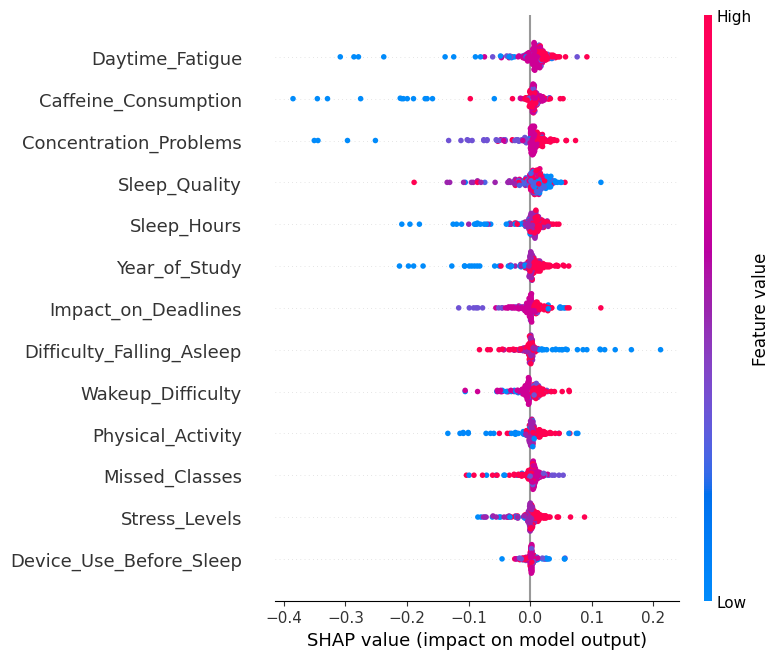

In [ ]:
# 5) SHAP beeswarm
shap.summary_plot(sv_pos, X_test_nosens, show=False)
plt.tight_layout()
plt.show()


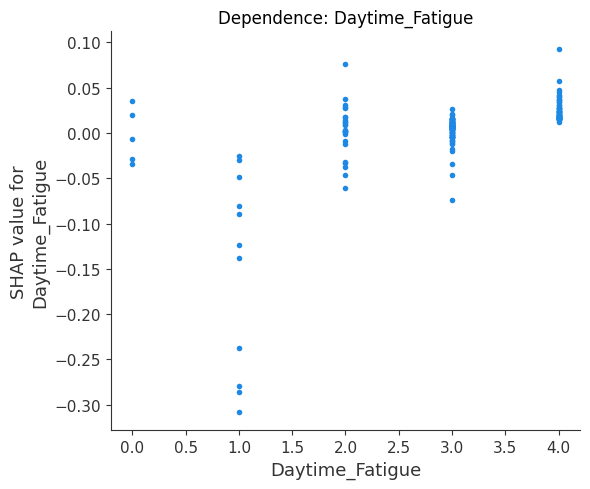

In [ ]:
# 6) Dependence plot top-1 feature
top1 = feat_importance.loc[0, "feature"]
shap.dependence_plot(top1, sv_pos, X_test_nosens, interaction_index=None, show=False)
plt.title(f"Dependence: {top1}")
plt.tight_layout()
plt.show()

# Dice-ml

In [ ]:
%pip install dice-ml --quiet


In [ ]:
# ===========================
# Counterfactual Explanations with DiCE (Local + Global) — FIXED
# ===========================
import numpy as np
import pandas as pd
import dice_ml

# ---------- 0) CONFIG ----------
N_STUDENTS       = 50           # số học sinh cần sinh CF trong batch global
TOTAL_CFS        = 3            # số counterfactuals cho mỗi học sinh
FREEZE_COLS      = ["Year_of_Study"]  # không cho thay đổi cột này (nếu có)
PERMITTED_RANGES = {
    # "Sleep_Hours": [0, 12],
    # "Stress_Levels": [0, 4],
}

# ---------- 1) DiCE Data & Model ----------
outcome_name = "target"
train_for_dice = Xtr.copy()
train_for_dice[outcome_name] = y_train.values

d = dice_ml.Data(
    dataframe=train_for_dice,
    continuous_features=list(Xtr.columns),   # giữ nguyên như bạn đang dùng
    categorical_features=[],                 # thêm nếu có biến danh nghĩa
    outcome_name=outcome_name,
    immutable_features=[c for c in FREEZE_COLS if c in train_for_dice.columns]
)

m = dice_ml.Model(model=final_base_clf, backend='sklearn', model_type='classifier')
exp = dice_ml.Dice(d, m, method='genetic')

# ---------- 2) LOCAL CFs (ví dụ 4 học sinh đầu) ----------
x_query_local = Xte.iloc[:4].copy()
features_to_vary_local = [c for c in Xtr.columns if c not in FREEZE_COLS]

local_cf = exp.generate_counterfactuals(
    query_instances=x_query_local,
    total_CFs=TOTAL_CFS,
    desired_class="opposite",                 # lật sang lớp đối nghịch (mục tiêu 0)
    features_to_vary=features_to_vary_local,
    permitted_range=PERMITTED_RANGES if PERMITTED_RANGES else None
)
print("\n=== Local CFs (first 4 students, show only changes) ===")
local_cf.visualize_as_dataframe(show_only_changes=True)

# ---------- 3) GLOBAL CFs: CHỈ CHỌN HỌC SINH AT-RISK (=1) ----------
scores_te = final_base_clf.predict_proba(Xte)[:, 1]
preds_te  = final_base_clf.predict(Xte)

# chỉ lấy các mẫu dự đoán at-risk
cand_idx = Xte.index[preds_te == 1]
idx_list = cand_idx[:N_STUDENTS].tolist()

X_batch = Xte.loc[idx_list].copy()
features_to_vary_global = [c for c in Xtr.columns if c not in FREEZE_COLS]

batch_cf = exp.generate_counterfactuals(
    query_instances=X_batch,
    total_CFs=TOTAL_CFS,
    desired_class="opposite",                 # mục tiêu: not-at-risk = 0
    features_to_vary=features_to_vary_global,
    permitted_range=PERMITTED_RANGES if PERMITTED_RANGES else None
)

# Gom kết quả CF + meta
cf_rows, meta_rows = [], []
for k, ex in enumerate(batch_cf.cf_examples_list):
    q_idx = idx_list[k]
    base_pred  = int(preds_te[Xte.index.get_loc(q_idx)])
    base_score = float(scores_te[Xte.index.get_loc(q_idx)])
    cfs = ex.final_cfs_df[Xtr.columns]       # chỉ cột feature (dòng 0 là original nếu có)

    for _, cf in cfs.iterrows():
        cf_rows.append(cf.values)
        meta_rows.append({"_query_index": q_idx, "_orig_pred": base_pred, "_orig_score": base_score})

CF = pd.DataFrame(cf_rows, columns=Xtr.columns)
META = pd.DataFrame(meta_rows)
CF_ALL = pd.concat([META, CF], axis=1)
print("\nCF_ALL (first 10 rows):")
print(CF_ALL.head(10))

# ---------- 4) EVALUATION: Validity (=1 nếu dự đoán CF là 0), L1 & L0 ----------
# Chuẩn hoá L1 theo biên độ từng biến (đẹp hơn tổng L1 thô)
_ranges = {c: float(max(1e-9, Xtr[c].max() - Xtr[c].min())) for c in Xtr.columns}

def predict_label(xrow):
    return int(final_base_clf.predict(pd.DataFrame([xrow], columns=Xtr.columns))[0])

def validity(cf_row):
    # hợp lệ nếu CF dự đoán là 0 (not-at-risk)
    return 1 if predict_label(cf_row) == 0 else 0

def l1_proximity_norm(base_x, cf_x):
    diffs = np.abs(base_x.values - cf_x.values)
    norm  = np.array([_ranges[c] for c in Xtr.columns], dtype=float)
    return float((diffs / norm).sum())

def sparsity_L0(base_x, cf_x):
    return int(np.sum(~np.isclose(base_x.values, cf_x.values)))

eval_rows = []
for i, r in CF_ALL.iterrows():
    qidx  = r["_query_index"]
    base_x = X_batch.loc[qidx, Xtr.columns]
    cf_x   = r[Xtr.columns]
    eval_rows.append({
        "validity": validity(cf_x),
        "proximity_L1": l1_proximity_norm(base_x, cf_x),
        "sparsity": sparsity_L0(base_x, cf_x)
    })

EVAL = pd.DataFrame(eval_rows)
print("\n=== Global CF evaluation (validity / proximity_L1 / sparsity) ===")
print(EVAL.describe())

# ---------- 5) THỐNG KÊ ĐẶC TRƯNG THAY ĐỔI ----------
change_records = []
for i, r in CF_ALL.iterrows():
    qidx  = r["_query_index"]
    base_x = X_batch.loc[qidx, Xtr.columns]
    cf_x   = r[Xtr.columns]
    diff_mask = ~np.isclose(base_x.values, cf_x.values)
    changed_cols = Xtr.columns[diff_mask]
    for col in changed_cols:
        delta = float(cf_x[col] - base_x[col])
        change_records.append({"feature": col, "delta": delta})

if change_records:
    CHANGES = pd.DataFrame(change_records)
    global_change_summary = (
        CHANGES.groupby("feature").agg(
            n_changes = ("delta", "count"),
            mean_abs_change = ("delta", lambda x: float(np.mean(np.abs(x)))),
            pct_increase = ("delta", lambda x: float(100.0*np.mean(np.array(x) > 0))),
            pct_decrease = ("delta", lambda x: float(100.0*np.mean(np.array(x) < 0)))
        ).sort_values(["n_changes", "mean_abs_change"], ascending=False)
    )
    print("\n=== Global CF change summary (top 15) ===")
    print(global_change_summary.head(15))
else:
    print("\n(No feature changes recorded in CFs; check constraints/features_to_vary.)")

# ---------- 6) Xem thay đổi của 1 học sinh đầu tiên ----------
if len(idx_list) > 0:
    print("\n=== Show only changes for the first student in the batch ===")
    first_idx = idx_list[0]
    base_x = X_batch.loc[first_idx, Xtr.columns]
    cf_first = CF_ALL[CF_ALL["_query_index"] == first_idx][Xtr.columns]

    def show_only_changes(base_series, cf_frame):
        out = []
        for i, row in cf_frame.iterrows():
            changed = {col: (base_series[col], row[col])
                       for col in cf_frame.columns
                       if not np.isclose(base_series[col], row[col])}
            out.append({"cf_row": i, "changes": changed})
        return out

    changes_preview = show_only_changes(base_x, cf_first)
    for item in changes_preview:
        print(item)


100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


=== Local CFs (first 4 students, show only changes) ===
Query instance (original outcome : 1)


,Year_of_Study,Difficulty_Falling_Asleep,Sleep_Hours,Wakeup_Difficulty,Sleep_Quality,Concentration_Problems,Daytime_Fatigue,Missed_Classes,Impact_on_Deadlines,Device_Use_Before_Sleep,Caffeine_Consumption,Physical_Activity,Stress_Levels,target
0,2.0,2.0,3.0,4.0,4.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0,2.0,1



Diverse Counterfactual set (new outcome: 0)


,Year_of_Study,Difficulty_Falling_Asleep,Sleep_Hours,Wakeup_Difficulty,Sleep_Quality,Concentration_Problems,Daytime_Fatigue,Missed_Classes,Impact_on_Deadlines,Device_Use_Before_Sleep,Caffeine_Consumption,Physical_Activity,Stress_Levels,target
0,-,3.0,-,-,3.0,4.0,3.0,-,3.0,-,-,3.0,-,0.0
0,-,4.0,-,3.0,1.0,3.0,3.0,-,3.0,-,-,-,-,0.0
0,-,3.0,-,3.0,3.0,3.0,3.0,4.0,-,-,-,-,3.0,0.0


Query instance (original outcome : 1)


,Year_of_Study,Difficulty_Falling_Asleep,Sleep_Hours,Wakeup_Difficulty,Sleep_Quality,Concentration_Problems,Daytime_Fatigue,Missed_Classes,Impact_on_Deadlines,Device_Use_Before_Sleep,Caffeine_Consumption,Physical_Activity,Stress_Levels,target
0,3.0,4.0,3.0,2.0,0.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,1



Diverse Counterfactual set (new outcome: 0)


,Year_of_Study,Difficulty_Falling_Asleep,Sleep_Hours,Wakeup_Difficulty,Sleep_Quality,Concentration_Problems,Daytime_Fatigue,Missed_Classes,Impact_on_Deadlines,Device_Use_Before_Sleep,Caffeine_Consumption,Physical_Activity,Stress_Levels,target
0,-,-,-,3.0,-,-,-,4.0,-,-,4.0,4.0,-,0.0
0,-,-,-,3.0,1.0,-,3.0,-,-,4.0,-,4.0,-,0.0
0,-,-,-,3.0,4.0,-,3.0,4.0,-,-,4.0,-,3.0,0.0


Query instance (original outcome : 1)


,Year_of_Study,Difficulty_Falling_Asleep,Sleep_Hours,Wakeup_Difficulty,Sleep_Quality,Concentration_Problems,Daytime_Fatigue,Missed_Classes,Impact_on_Deadlines,Device_Use_Before_Sleep,Caffeine_Consumption,Physical_Activity,Stress_Levels,target
0,1.0,3.0,4.0,3.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,1.0,1



Diverse Counterfactual set (new outcome: 0)


,Year_of_Study,Difficulty_Falling_Asleep,Sleep_Hours,Wakeup_Difficulty,Sleep_Quality,Concentration_Problems,Daytime_Fatigue,Missed_Classes,Impact_on_Deadlines,Device_Use_Before_Sleep,Caffeine_Consumption,Physical_Activity,Stress_Levels,target
0,-,-,-,-,2.0,3.0,3.0,-,-,-,-,-,2.0,0.0
0,-,-,3.0,-,1.0,-,3.0,-,-,-,-,-,2.0,0.0
0,-,-,-,-,0.0,3.0,3.0,-,-,-,-,-,2.0,0.0


Query instance (original outcome : 1)


,Year_of_Study,Difficulty_Falling_Asleep,Sleep_Hours,Wakeup_Difficulty,Sleep_Quality,Concentration_Problems,Daytime_Fatigue,Missed_Classes,Impact_on_Deadlines,Device_Use_Before_Sleep,Caffeine_Consumption,Physical_Activity,Stress_Levels,target
0,3.0,3.0,4.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,1



Diverse Counterfactual set (new outcome: 0)


,Year_of_Study,Difficulty_Falling_Asleep,Sleep_Hours,Wakeup_Difficulty,Sleep_Quality,Concentration_Problems,Daytime_Fatigue,Missed_Classes,Impact_on_Deadlines,Device_Use_Before_Sleep,Caffeine_Consumption,Physical_Activity,Stress_Levels,target
0,-,4.0,3.0,-,-,3.0,-,-,-,-,-,-,-,0.0
0,-,-,3.0,-,3.0,3.0,-,-,4.0,-,-,4.0,-,0.0
0,-,4.0,3.0,4.0,-,-,-,-,4.0,4.0,-,-,-,0.0


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]



CF_ALL (first 10 rows):
   _query_index  _orig_pred  _orig_score  Year_of_Study  \
0           871           1     0.999959            2.0   
1           871           1     0.999959            2.0   
2           871           1     0.999959            2.0   
3           839           1     0.999898            3.0   
4           839           1     0.999898            3.0   
5           839           1     0.999898            3.0   
6            48           1     0.671116            1.0   
7            48           1     0.671116            1.0   
8            48           1     0.671116            1.0   
9           960           1     0.998729            3.0   

   Difficulty_Falling_Asleep  Sleep_Hours  Wakeup_Difficulty  Sleep_Quality  \
0                        3.0          3.0                4.0            3.0   
1                        4.0          3.0                3.0            1.0   
2                        3.0          3.0                3.0            3.0   
3        


#changes by group:
 group
sleep        258
academic     173
lifestyle    141
stress       103
Name: feature, dtype: int64

#increase/decrease by group:
 direction  decrease  increase
group                        
academic         84        89
lifestyle        70        71
sleep           132       126
stress           54        49

Chi-square test across groups vs features: chi2=2025.000, dof=33, p=0

Spearman(proximity_L1, sparsity) = 0.778 (p=2.064e-31)


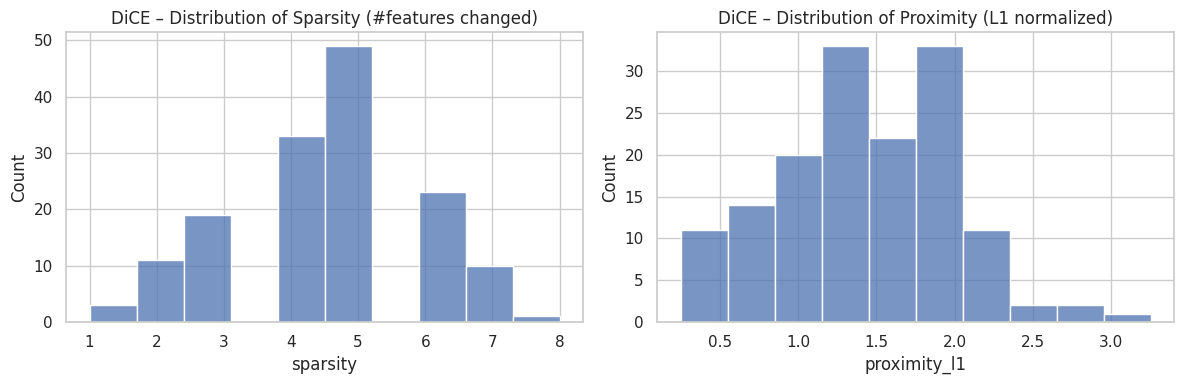

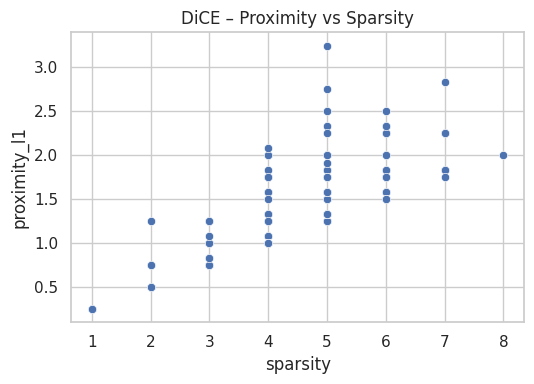

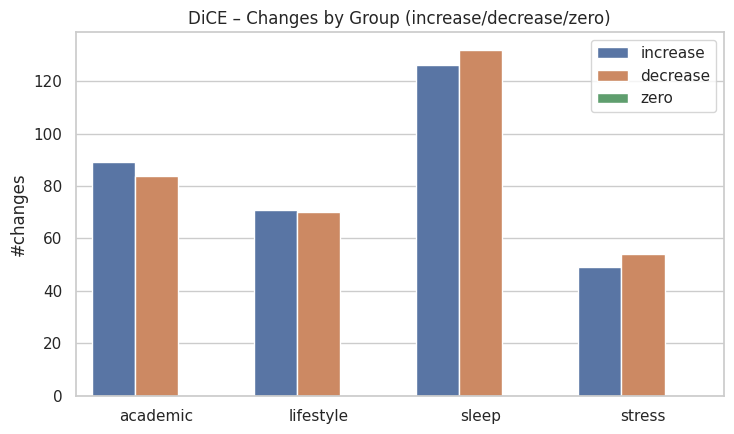


Top feature changes (DiCE):
                            n_changes  mean_abs_change  pct_increase  \
feature                                                               
Sleep_Quality                     83         1.903614     62.650602   
Concentration_Problems            68         1.205882     36.764706   
Sleep_Hours                       65         1.092308     18.461538   
Wakeup_Difficulty                 58         1.051724     41.379310   
Daytime_Fatigue                   56         1.089286     53.571429   
Caffeine_Consumption              55         1.272727     49.090909   
Impact_on_Deadlines               53         1.094340     58.490566   
Difficulty_Falling_Asleep         52         1.230769     73.076923   
Missed_Classes                    52         1.134615     63.461538   
Physical_Activity                 51         1.176471     41.176471   
Stress_Levels                     47         1.021277     40.425532   
Device_Use_Before_Sleep           35         1.

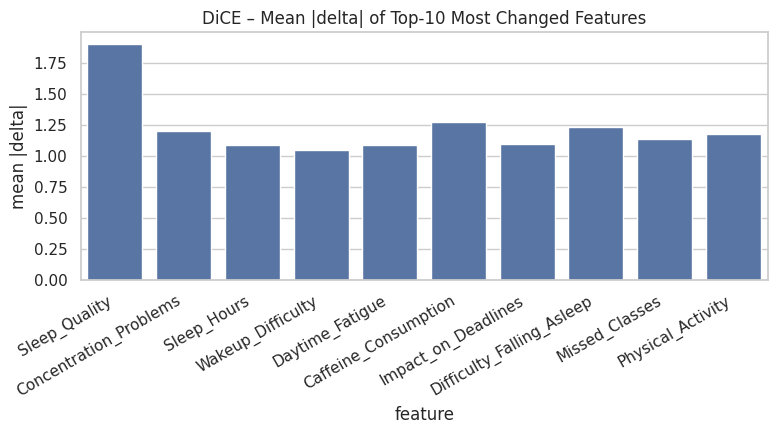

In [ ]:
# ===========================
# DiCE — Visualization & Analysis (matching Wachter side)
# - Optional rounding to ordinal levels
# - Recompute EVAL/CHANGES after rounding
# - Same style plots: distributions, scatter, group counts, chi-square
# ===========================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, spearmanr

# ---------- 0) CONFIG ----------
# Nếu tất cả feature là ordinal (0–4 hoặc 1–4), bật rounding để so sánh công bằng
ROUND_TO_INTS = True

# Nếu tất cả dùng cùng dải {0,1,2,3,4} thì để None.
# Nếu mỗi cột có dải riêng, khai báo ở đây, ví dụ:
# ALLOWED_LEVELS = {
#     "Sleep_Quality": [0,1,2,3,4],
#     "Sleep_Hours":   [1,2,3,4],   # ví dụ nếu bạn encode 1-4 cho thang 4 bậc
#     ...
# }
ALLOWED_LEVELS = None  # hoặc điền dict như ở trên

# Gom nhóm feature (sao cho khớp với paper của bạn)
feature_groups = {
    "sleep": ["Sleep_Hours", "Sleep_Quality", "Difficulty_Falling_Asleep", "Wakeup_Difficulty"],
    "stress": ["Stress_Levels", "Daytime_Fatigue"],
    "lifestyle": ["Device_Use_Before_Sleep", "Caffeine_Consumption", "Physical_Activity"],
    "academic": ["Concentration_Problems", "Missed_Classes", "Impact_on_Deadlines"]
}
# ---------------------------------------------------------

# ---------- 1) Helpers ----------
def _round_to_allowed(x, allowed):
    """Làm tròn x về mức gần nhất trong 'allowed' (list/array các mức hợp lệ)."""
    allowed = np.asarray(allowed, dtype=float)
    # khoảng cách tuyệt đối đến từng mức -> chọn mức gần nhất
    idx = np.argmin(np.abs(allowed - float(x)))
    return float(allowed[idx])

def _round_df_ordinals(df_feat: pd.DataFrame, Xtr: pd.DataFrame, allowed_map: dict | None):
    """Làm tròn toàn bộ DataFrame features về bậc ordinal.
       - Nếu allowed_map is None: dùng round() và clip theo min/max của Xtr (coi như thang integer liên tiếp).
       - Nếu allowed_map là dict: map từng cột theo list mức cho trước (không cần clip).
    """
    out = df_feat.copy()
    if allowed_map is None:
        # giả định mức là integer liên tiếp; clip theo min/max train
        mins = Xtr.min(axis=0).astype(float)
        maxs = Xtr.max(axis=0).astype(float)
        out = np.rint(out.values).astype(float)
        out = np.clip(out, mins.values.reshape(1, -1), maxs.values.reshape(1, -1))
        out = pd.DataFrame(out, columns=df_feat.columns, index=df_feat.index)
        return out
    else:
        # mỗi cột theo dải riêng trong allowed_map
        for c in df_feat.columns:
            if c in allowed_map:
                out[c] = out[c].apply(lambda v: _round_to_allowed(v, allowed_map[c]))
            else:
                # nếu không chỉ định, fallback round + clip theo train
                vmin, vmax = float(Xtr[c].min()), float(Xtr[c].max())
                out[c] = np.clip(np.rint(out[c].values).astype(float), vmin, vmax)
        return out

def _recompute_eval_and_changes(CF_ALL_feat: pd.DataFrame, CF_ALL_meta: pd.DataFrame,
                                Xte: pd.DataFrame, feature_names: list[str],
                                final_base_clf):
    """Tạo lại EVAL & CHANGES từ CF_ALL đã (có thể) được làm tròn."""
    # Lấy chỉ số base
    idxs = CF_ALL_meta["_query_index"].values
    X_base = Xte.loc[idxs, feature_names].reset_index(drop=True)
    X_cf   = CF_ALL_feat.reset_index(drop=True)

    # ranges cho L1 chuẩn hoá
    ranges = np.array([max(1e-9, Xtr[c].max() - Xtr[c].min()) for c in feature_names], dtype=float)

    # validity: predict label (yêu cầu model đang ở scope: final_base_clf)
    def _pred_label_np(row):
        return int(final_base_clf.predict(np.asarray(row).reshape(1, -1), validate_features=False)[0])

    eval_rows = []
    change_records = []
    for i in range(len(X_cf)):
        base_x = X_base.iloc[i].values
        cf_x   = X_cf.iloc[i].values

        # validity vs lớp 0 (cùng convention như bạn đang dùng)
        validity = 1 if _pred_label_np(cf_x) == 0 else 0

        # L1 chuẩn hoá
        proximity = float((np.abs(base_x - cf_x) / ranges).sum())

        # L0 (đếm khác biệt)
        sparsity = int(np.sum(~np.isclose(base_x, cf_x)))

        eval_rows.append({"validity": validity, "proximity_L1": proximity, "sparsity": sparsity})

        # ghi lại thay đổi từng feature
        diff_mask = ~np.isclose(base_x, cf_x)
        for j, c in enumerate(feature_names):
            if diff_mask[j]:
                change_records.append({"feature": c, "delta": float(cf_x[j] - base_x[j])})

    EVAL = pd.DataFrame(eval_rows)
    CHANGES = pd.DataFrame(change_records)
    return EVAL, CHANGES

def _attach_group(CHANGES: pd.DataFrame, feature_groups: dict):
    """Gắn nhóm cho mỗi feature thay đổi."""
    def map_group(f):
        for g, feats in feature_groups.items():
            if f in feats: return g
        return "other"
    CHANGES = CHANGES.copy()
    CHANGES["group"] = CHANGES["feature"].map(map_group)
    return CHANGES

# ---------- 2) Chuẩn bị dữ liệu từ CF_ALL ----------
# CF_ALL = META + features. Ta tách META & FEATURE block
meta_cols = [c for c in CF_ALL.columns if c.startswith("_")]
CF_META   = CF_ALL[meta_cols].copy()
CF_FEATS  = CF_ALL[[c for c in CF_ALL.columns if c in feature_names]].copy()

# (tuỳ chọn) 2.1 Làm tròn CF về bậc ordinal để so sánh công bằng
if ROUND_TO_INTS:
    CF_FEATS = _round_df_ordinals(CF_FEATS, Xtr, ALLOWED_LEVELS)

# ---------- 3) Recompute EVAL & CHANGES (sau khi làm tròn, nếu có) ----------
EVAL, CHANGES = _recompute_eval_and_changes(CF_FEATS, CF_META, Xte, feature_names, final_base_clf)

# ---------- 4) Thống kê theo nhóm & kiểm định ----------
CHANGES = _attach_group(CHANGES, feature_groups)

# Đếm số thay đổi theo group
group_counts = CHANGES.groupby("group")["feature"].count().sort_values(ascending=False)
print("\n#changes by group:\n", group_counts)

# Phân rã tăng/giảm theo group
chg_dir = (CHANGES.assign(direction=lambda d: np.where(d["delta"] > 0, "increase",
                                                       np.where(d["delta"] < 0, "decrease", "zero")))
           .groupby(["group", "direction"])["feature"].count().unstack(fill_value=0))
print("\n#increase/decrease by group:\n", chg_dir)

# Chi-square (phân phối thay đổi theo group x feature)
cont_table = pd.crosstab(CHANGES["group"], CHANGES["feature"])
chi2, p, dof, expected = chi2_contingency(cont_table)
print(f"\nChi-square test across groups vs features: chi2={chi2:.3f}, dof={dof}, p={p:.4g}")

# Tương quan proximity vs sparsity
rho, pval = spearmanr(EVAL["proximity_L1"], EVAL["sparsity"])
print(f"\nSpearman(proximity_L1, sparsity) = {rho:.3f} (p={pval:.4g})")

# ---------- 5) Vẽ các hình tương tự Wachter ----------
sns.set(style="whitegrid")

# (A) Phân phối sparsity & proximity
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(EVAL["sparsity"], bins=10, ax=axes[0])
axes[0].set_title("DiCE – Distribution of Sparsity (#features changed)")
axes[0].set_xlabel("sparsity")

sns.histplot(EVAL["proximity_L1"], bins=10, ax=axes[1])
axes[1].set_title("DiCE – Distribution of Proximity (L1 normalized)")
axes[1].set_xlabel("proximity_l1")
plt.tight_layout()
plt.show()

# (B) Scatter proximity vs sparsity
plt.figure(figsize=(5.5, 4))
sns.scatterplot(x=EVAL["sparsity"], y=EVAL["proximity_L1"])
plt.title("DiCE – Proximity vs Sparsity")
plt.xlabel("sparsity")
plt.ylabel("proximity_l1")
plt.tight_layout()
plt.show()

# (C) Stacked bar increase/decrease theo group
chg_dir = chg_dir.reindex(columns=["increase","decrease","zero"], fill_value=0)

plot_df = chg_dir.reset_index().melt(
    id_vars="group",
    value_vars=["increase","decrease","zero"],
    var_name="direction",
    value_name="count"
)

plt.figure(figsize=(7.5, 4.5))
sns.barplot(data=plot_df, x="group", y="count", hue="direction")
plt.title("DiCE – Changes by Group (increase/decrease/zero)")
plt.xlabel("")
plt.ylabel("#changes")
plt.legend(title="")
plt.tight_layout()
plt.show()


# (D) Top feature thay đổi (mean|delta|)
feat_summary = (CHANGES.groupby("feature")
                .agg(n_changes=("delta","count"),
                     mean_abs_change=("delta", lambda x: float(np.mean(np.abs(x)))),
                     pct_increase=("delta", lambda x: 100.0*np.mean(np.array(x)>0)),
                     pct_decrease=("delta", lambda x: 100.0*np.mean(np.array(x)<0)))
                .sort_values(["n_changes","mean_abs_change"], ascending=False))

print("\nTop feature changes (DiCE):\n", feat_summary.head(15))

plt.figure(figsize=(8, 4.5))
top_feats = feat_summary.head(10).reset_index()
sns.barplot(data=top_feats, x="feature", y="mean_abs_change")
plt.title("DiCE – Mean |delta| of Top-10 Most Changed Features")
plt.xticks(rotation=30, ha="right")
plt.ylabel("mean |delta|")
plt.tight_layout()
plt.show()

# **Wacher**

In [ ]:
# ===========================
# Counterfactual Explanations — Wachter (paper-style) Local + Global
# - KHÔNG dùng features_to_vary (bám sát paper gốc): mọi biến đều có thể thay đổi
#   trừ các biến "đóng băng" trong FREEZE_COLS
# - TẤT CẢ BIẾN LÀ ORDINAL -> luôn làm tròn về số nguyên trong quá trình tối ưu
# - Hinge loss (target proba), dynamic-C, diversity penalty, DE fallback
# - LightGBM-safe predictions (validate_features=False)
# ===========================
import numpy as np
import pandas as pd
from scipy.optimize import minimize, differential_evolution
import warnings

# (optional) tắt cảnh báo tên cột LightGBM
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMClassifier was fitted with feature names",
    category=UserWarning
)

# ---------- 0) CONFIG ----------
N_STUDENTS       = 50          # số HS cần sinh CF (global batch)
TOTAL_CFS        = 3           # số CF mỗi HS
FREEZE_COLS      = ["Year_of_Study"]  # các cột cố định, không cho thay đổi

# (tùy chọn) ràng buộc giá trị hợp lệ theo miền cho từng biến
PERMITTED_RANGES = {
    # ví dụ:
    # "Sleep_Hours": (0, 12),
    # "Stress_Levels": (0, 4),
}

# Wachter-specific
TARGET_PROBA  = 0.80    # p(target) >= ngưỡng này xem như đạt
C_INIT        = 2.0     # trọng số term phân loại (sẽ tăng nếu chưa đạt)
LAMBDA_L1     = 0.5     # regularizer độ gần (L1 chuẩn hoá)

# Diversity (để các CF khác nhau)
DIVERSITY_W   = 0.10    # trọng số phạt đa dạng
DIVERSITY_SIG = 0.50    # thang khoảng cách cho exp(-||x-xj||/sig)

# Optimizer
LOCAL_K         = 4
LBFGS_MAXITER   = 200
LBFGS_RESTARTS  = 2
DE_MAXITER      = 100
DE_POPSIZE      = 16
DE_SEED         = 2025

# ---------- 1) PREP ----------
feature_names = list(Xtr.columns)
# dùng biên độ thật để chuẩn hoá L1
_ranges_vec = np.array([max(1e-9, Xtr[c].max() - Xtr[c].min()) for c in feature_names], dtype=float)

def _predict_proba_np(model, x_np):
    """LightGBM-safe predict_proba with validate_features=False."""
    if isinstance(x_np, pd.Series):
        x_np = x_np.values
    if x_np.ndim == 1:
        x_np = x_np.reshape(1, -1)
    return model.predict_proba(x_np, validate_features=False)

def _predict_label_np(model, x_np):
    return int(np.argmax(_predict_proba_np(model, x_np)[0]))

def _build_bounds_paper(x_orig_vec, permitted_ranges):
    """
    Paper-style: mọi biến đều có thể thay đổi trừ FREEZE_COLS.
    Bounds = PERMITTED_RANGES (nếu có) hoặc min/max train (+/-5% đệm).
    """
    bnds = []
    for i, col in enumerate(feature_names):
        if col in FREEZE_COLS:
            v = float(x_orig_vec[i])
            bnds.append((v, v))
            continue
        if permitted_ranges and (col in permitted_ranges):
            lo, hi = permitted_ranges[col]
            bnds.append((float(lo), float(hi)))
        else:
            lo, hi = float(Xtr[col].min()), float(Xtr[col].max())
            span = hi - lo
            if span > 0:
                lo -= 0.05 * span
                hi += 0.05 * span
            bnds.append((lo, hi))
    return bnds

def _round_and_clip_vector(vec, bounds, round_fn=np.rint):
    """
    Làm tròn integer cho TẤT CẢ biến (ordinal), sau đó clip vào bounds (cũng integer hoá).
    """
    out = np.array(vec, dtype=float)
    for i in range(len(feature_names)):
        out[i] = round_fn(out[i])                       # làm tròn
        lo, hi = bounds[i]
        # clip trong biên, đảm bảo nguyên (ceil/floor)
        out[i] = float(np.clip(out[i], np.ceil(lo), np.floor(hi)))
    return out

# ---------- 2) Wachter loss (hinge) + Diversity ----------
def wachter_cost_hinge(x_prime, x_orig, model, desired_class, C, lam, bounds):
    # Làm tròn ngay trong loss -> hướng tối ưu về nghiệm nguyên
    x_int = _round_and_clip_vector(x_prime, bounds)
    p_des   = _predict_proba_np(model, np.array(x_int))[0, int(desired_class)]
    cls_hg  = max(0.0, TARGET_PROBA - float(p_des))**2
    prox_l1 = np.sum(np.abs(x_int - x_orig) / _ranges_vec)
    return C * cls_hg + lam * prox_l1

def diversity_penalty(x_prime, cfs_so_far, bounds):
    if not cfs_so_far:
        return 0.0
    x = _round_and_clip_vector(x_prime, bounds)
    pen = 0.0
    for prev in cfs_so_far:
        d = np.linalg.norm((x - prev) / _ranges_vec)
        pen += np.exp(-d / max(1e-9, DIVERSITY_SIG))
    return DIVERSITY_W * pen

# ---------- 3) DE fallback (vectorized + rounding bên trong) ----------
def _de_fallback(x_orig, model, desired_class, bounds, lam, cfs_so_far):
    d_local = len(feature_names)

    def obj_vec(X):
        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        else:
            if X.shape[1] != d_local and X.shape[0] == d_local:
                X = X.T
            if X.shape[1] != d_local:
                X = X.reshape(-1, d_local)

        # Làm tròn & clip theo bounds cho từng cá thể
        Xr = np.zeros_like(X)
        for i in range(X.shape[0]):
            Xr[i] = _round_and_clip_vector(X[i], bounds)

        P   = _predict_proba_np(model, Xr)[:, int(desired_class)]
        cls = np.maximum(0.0, TARGET_PROBA - P)**2
        prox = np.sum(np.abs(Xr - x_orig.reshape(1, -1)) / _ranges_vec.reshape(1, -1), axis=1)

        if cfs_so_far:
            div = np.zeros(X.shape[0], dtype=float)
            for prev in cfs_so_far:
                d = np.linalg.norm((Xr - prev.reshape(1, -1)) / _ranges_vec.reshape(1, -1), axis=1)
                div += np.exp(-d / max(1e-9, DIVERSITY_SIG))
            div *= DIVERSITY_W
            return cls + lam * prox + div
        else:
            return cls + lam * prox

    res = differential_evolution(
        obj_vec, bounds=bounds, strategy='best1bin',
        maxiter=DE_MAXITER, popsize=DE_POPSIZE, seed=DE_SEED,
        recombination=0.7, mutation=(0.5, 1.0),
        polish=True, tol=1e-6, updating='deferred', workers=1, vectorized=True
    )
    x_cf = res.x.copy()
    x_cf = _round_and_clip_vector(x_cf, bounds)  # làm tròn & clip lần cuối
    return x_cf

# ---------- 4) Generate MULTIPLE CFs for ONE instance ----------
def generate_wachter_cfs_for_instance(query_instance: pd.Series,
                                      model,
                                      desired_label: int,
                                      total_cfs: int,
                                      permitted_ranges: dict | None):
    """
    Return: np.ndarray shape (total_cfs, d) — MỌI GIÁ TRỊ ĐÃ LÀ SỐ NGUYÊN
    Chiến lược mỗi CF:
      - L-BFGS-B với hinge loss (có rounding trong loss); tăng C nếu chưa đạt
      - Phạt đa dạng so với CF đã có
      - Nếu chưa đạt ngưỡng xác suất, fallback DE (cũng rounding trong objective)
    """
    x_orig = query_instance.values.astype(float)
    bounds = _build_bounds_paper(x_orig, permitted_ranges)

    cfs = []
    for _t in range(total_cfs):
        def objective_with_C(x, C_current):
            base = wachter_cost_hinge(x, x_orig, model, desired_label, C_current, LAMBDA_L1, bounds)
            return base + diversity_penalty(x, cfs, bounds)

        best_x, best_val = None, np.inf
        C_current = C_INIT

        # L-BFGS-B với tăng C
        for _phase in range(2):
            for k in range(1 + LBFGS_RESTARTS):
                x0 = x_orig.copy()
                if k > 0:
                    # jitter nhỏ trong bounds (loss sẽ tự round)
                    for i, (lo, hi) in enumerate(bounds):
                        if lo == hi:  # locked
                            continue
                        span = hi - lo
                        x0[i] = np.clip(x0[i] + np.random.uniform(-0.05*span, 0.05*span), lo, hi)

                res = minimize(
                    fun=lambda z: objective_with_C(z, C_current),
                    x0=x0, method='L-BFGS-B', bounds=bounds,
                    options={'maxiter': LBFGS_MAXITER}
                )
                if res.success:
                    val = objective_with_C(res.x, C_current)
                    if val < best_val:
                        best_val, best_x = val, res.x

                if best_x is not None:
                    # kiểm tra sau khi LÀM TRÒN
                    best_x_int = _round_and_clip_vector(best_x, bounds)
                    p = _predict_proba_np(model, best_x_int)[0, int(desired_label)]
                    if p >= TARGET_PROBA:
                        break

            if best_x is not None:
                best_x_int = _round_and_clip_vector(best_x, bounds)
                p_check = _predict_proba_np(model, best_x_int)[0, int(desired_label)]
                if p_check >= TARGET_PROBA:
                    break
            C_current *= 5.0  # mạnh hơn

        # Fallback DE nếu cần
        if best_x is None:
            best_x_int = _de_fallback(x_orig, model, desired_label, bounds, LAMBDA_L1, cfs)
        else:
            best_x_int = _round_and_clip_vector(best_x, bounds)
            if _predict_proba_np(model, best_x_int)[0, int(desired_label)] < TARGET_PROBA:
                best_x_int = _de_fallback(x_orig, model, desired_label, bounds, LAMBDA_L1, cfs)

        # lưu CF (đã integer & clip)
        cfs.append(best_x_int.astype(float))

    return np.vstack(cfs) if cfs else np.empty((0, len(feature_names)))

# ---------- 5) LOCAL CFs (4 học sinh đầu, TOTAL_CFS/mỗi người) ----------
x_query_local = Xte.iloc[:4].copy()

local_cf_rows, local_meta = [], []
for ridx, (_, row) in enumerate(x_query_local.iterrows()):
    base_pred = _predict_label_np(final_base_clf, row.values)
    desired   = 1 - base_pred  # "opposite"
    cfs = generate_wachter_cfs_for_instance(
        row, final_base_clf,
        desired_label=desired, total_cfs=TOTAL_CFS,
        permitted_ranges=PERMITTED_RANGES if PERMITTED_RANGES else None
    )
    for j in range(cfs.shape[0]):
        local_cf_rows.append(cfs[j, :])
        local_meta.append({"_query_row": ridx, "_orig_pred": base_pred})

LOCAL_CF = pd.DataFrame(local_cf_rows, columns=feature_names) if local_cf_rows else pd.DataFrame(columns=feature_names)
LOCAL_META = pd.DataFrame(local_meta)
LOCAL_ALL = pd.concat([LOCAL_META, LOCAL_CF], axis=1) if not LOCAL_CF.empty else LOCAL_META.copy()

print("\n=== Local CFs (first 4 students, show only changes) ===")
if not LOCAL_ALL.empty:
    for ridx in LOCAL_ALL["_query_row"].unique():
        base_x = x_query_local.iloc[int(ridx)][feature_names]
        cf_rows = LOCAL_ALL[LOCAL_ALL["_query_row"] == ridx][feature_names]
        for j, (_, cf_row) in enumerate(cf_rows.iterrows()):
            # ép hiển thị số nguyên
            changed = {c: (int(base_x[c]), int(cf_row[c]))
                       for c in feature_names if not np.isclose(base_x[c], cf_row[c])}
            print(f"[row {ridx}] CF#{j+1}: {changed}")
else:
    print("(No LOCAL CFs generated.)")

# ---------- 6) GLOBAL CFs: chỉ học sinh at-risk (=1), TOTAL_CFS mỗi học sinh ----------
scores_te = _predict_proba_np(final_base_clf, Xte.values)[:, 1]
preds_te  = final_base_clf.predict(Xte.values, validate_features=False)

cand_idx = Xte.index[preds_te == 1]
idx_list = cand_idx[:N_STUDENTS].tolist()

X_batch = Xte.loc[idx_list].copy()

cf_rows, meta_rows = [], []
for q_idx in idx_list:
    base_pred  = int(preds_te[Xte.index.get_loc(q_idx)])
    base_score = float(scores_te[Xte.index.get_loc(q_idx)])

    cfs = generate_wachter_cfs_for_instance(
        X_batch.loc[q_idx], final_base_clf,
        desired_label=0, total_cfs=TOTAL_CFS,
        permitted_ranges=PERMITTED_RANGES if PERMITTED_RANGES else None
    )
    for j in range(cfs.shape[0]):
        cf_rows.append(cfs[j, :])
        meta_rows.append({"_query_index": q_idx, "_orig_pred": base_pred, "_orig_score": base_score})

CF = pd.DataFrame(cf_rows, columns=feature_names) if cf_rows else pd.DataFrame(columns=feature_names)
META = pd.DataFrame(meta_rows)
CF_ALL = pd.concat([META, CF], axis=1) if not CF.empty else META.copy()
print("\nCF_ALL (first 10 rows):")
print(CF_ALL.head(10))

# ---------- 7) EVALUATION: Validity, L1 (normalized), L0 ----------
def evaluate_wachter_cfs(cf_all_df, x_batch_df, feature_names, model, target_label=0):
    """Evaluate Wachter CFs."""
    _ranges = {c: float(max(1e-9, Xtr[c].max() - Xtr[c].min())) for c in feature_names}

    def predict_label(xrow):
        return int(model.predict(np.asarray(xrow).reshape(1, -1), validate_features=False)[0])

    def validity(cf_row):
        return 1 if predict_label(cf_row) == target_label else 0

    def l1_proximity_norm(base_x, cf_x):
        diffs = np.abs(base_x.values - cf_x.values)
        norm  = np.array([_ranges[c] for c in feature_names], dtype=float)
        return float((diffs / norm).sum())

    def sparsity_L0(base_x, cf_x):
        return int(np.sum(~np.isclose(base_x.values, cf_x.values)))

    eval_rows = []
    for i, r in cf_all_df.iterrows():
        qidx  = r["_query_index"]
        if qidx not in x_batch_df.index:
            continue
        base_x = x_batch_df.loc[qidx, feature_names]
        cf_x   = r[feature_names]
        eval_rows.append({
            "validity": validity(cf_x),
            "proximity_L1": l1_proximity_norm(base_x, cf_x),
            "sparsity": sparsity_L0(base_x, cf_x)
        })
    return pd.DataFrame(eval_rows) if eval_rows else pd.DataFrame(columns=["validity","proximity_L1","sparsity"])

EVAL = evaluate_wachter_cfs(CF_ALL, X_batch, feature_names, final_base_clf, target_label=0)

print("\n=== Global CF evaluation (validity / proximity_L1 / sparsity) ===")
print(EVAL.describe() if not EVAL.empty else "(no CFs to evaluate)")

# ---------- 8) THỐNG KÊ ĐẶC TRƯNG THAY ĐỔI ----------
def analyze_wachter_changes(cf_all_df, x_batch_df, feature_names):
    """Analyze feature changes in Wachter CFs."""
    change_records = []
    for i, r in cf_all_df.iterrows():
        qidx  = r["_query_index"]
        if qidx not in x_batch_df.index:
            continue
        base_x = x_batch_df.loc[qidx, feature_names]
        cf_x   = r[feature_names]
        diff_mask = ~np.isclose(base_x.values, cf_x.values)
        changed_cols = np.array(feature_names)[diff_mask]
        for col in changed_cols:
            delta = float(cf_x[col] - base_x[col])
            change_records.append({"feature": col, "delta": delta})

    if change_records:
        changes_df = pd.DataFrame(change_records)
        global_change_summary = (
            changes_df.groupby("feature").agg(
                n_changes = ("delta", "count"),
                mean_abs_change = ("delta", lambda x: float(np.mean(np.abs(x)))),
                pct_increase = ("delta", lambda x: float(100.0*np.mean(np.array(x) > 0))),
                pct_decrease = ("delta", lambda x: float(100.0*np.mean(np.array(x) < 0)))
            ).sort_values(["n_changes", "mean_abs_change"], ascending=False)
        )
        return changes_df, global_change_summary
    else:
        return pd.DataFrame(), pd.DataFrame()

CHANGES, global_change_summary = analyze_wachter_changes(CF_ALL, X_batch, feature_names)


if not global_change_summary.empty:
    print("\n=== Global CF change summary (top 15) ===")
    print(global_change_summary.head(15))
else:
    print("\n(No feature changes recorded for Wachter.)")

# ---------- 9) Show only changes cho học sinh đầu tiên ----------
if len(idx_list) > 0:
    print("\n=== Show only changes for the first student in the batch ===")
    first_idx = idx_list[0]
    base_x = X_batch.loc[first_idx, feature_names]
    cf_first = CF_ALL[CF_ALL["_query_index"] == first_idx][feature_names]

    def show_only_changes(base_series, cf_frame):
        out = []
        for i, row in cf_frame.iterrows():
            changed = {col: (int(base_series[col]), int(row[col]))
                       for col in cf_frame.columns
                       if not np.isclose(base_series[col], row[col])}
            out.append({"cf_row": i, "changes": changed})
        return out

    for item in show_only_changes(base_x, cf_first):
        print(item)


=== Local CFs (first 4 students, show only changes) ===
[row 0] CF#1: {'Difficulty_Falling_Asleep': (2, 1), 'Concentration_Problems': (2, 0), 'Caffeine_Consumption': (3, 1)}
[row 0] CF#2: {'Difficulty_Falling_Asleep': (2, 1), 'Wakeup_Difficulty': (4, 3), 'Caffeine_Consumption': (3, 1)}
[row 0] CF#3: {'Wakeup_Difficulty': (4, 3), 'Concentration_Problems': (2, 0), 'Caffeine_Consumption': (3, 1)}
[row 1] CF#1: {'Sleep_Quality': (0, 1), 'Caffeine_Consumption': (3, 1)}
[row 1] CF#2: {'Sleep_Quality': (0, 1), 'Caffeine_Consumption': (3, 1)}
[row 1] CF#3: {'Daytime_Fatigue': (4, 1), 'Physical_Activity': (3, 4)}
[row 2] CF#1: {'Sleep_Quality': (3, 2)}
[row 2] CF#2: {'Device_Use_Before_Sleep': (3, 2)}
[row 2] CF#3: {'Physical_Activity': (3, 2)}
[row 3] CF#1: {'Difficulty_Falling_Asleep': (3, 4), 'Sleep_Hours': (4, 3), 'Concentration_Problems': (4, 3)}
[row 3] CF#2: {'Difficulty_Falling_Asleep': (3, 4), 'Sleep_Hours': (4, 3), 'Impact_on_Deadlines': (3, 2)}
[row 3] CF#3: {'Difficulty_Falling_Asl

## diagram


Top feature changes (Wachter):
                           n_changes  mean_abs_change  pct_increase  \
feature                                                               
Caffeine_Consumption              55         1.727273      9.090909   
Concentration_Problems            37         1.081081     13.513514   
Sleep_Hours                       36         1.027778      8.333333   
Wakeup_Difficulty                 34         1.029412      2.941176   
Difficulty_Falling_Asleep         30         1.000000     76.666667   
Sleep_Quality                     29         1.068966     68.965517   
Daytime_Fatigue                   24         1.291667      8.333333   
Stress_Levels                     22         1.000000      0.000000   
Physical_Activity                 20         1.150000     35.000000   
Impact_on_Deadlines               19         1.000000     15.789474   
Missed_Classes                    18         1.055556     77.777778   
Device_Use_Before_Sleep            8         

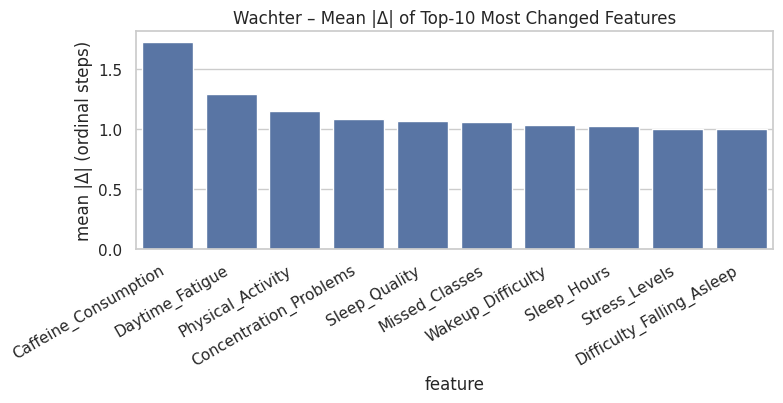


Chi-square test across groups vs features: (bỏ qua ở bản feature-level)
Spearman(proximity_L1, sparsity) = 0.912 (p=3.4e-59)


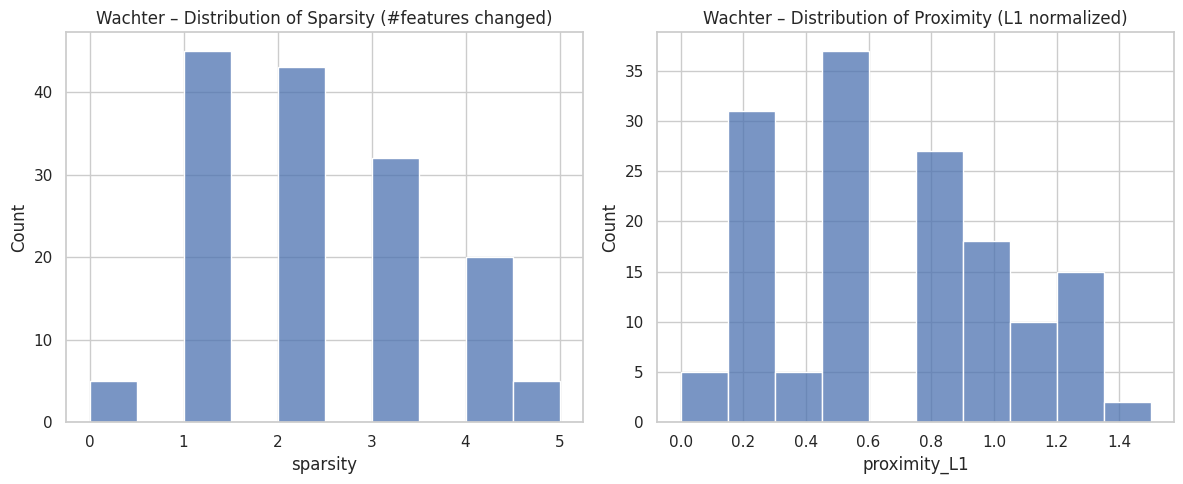

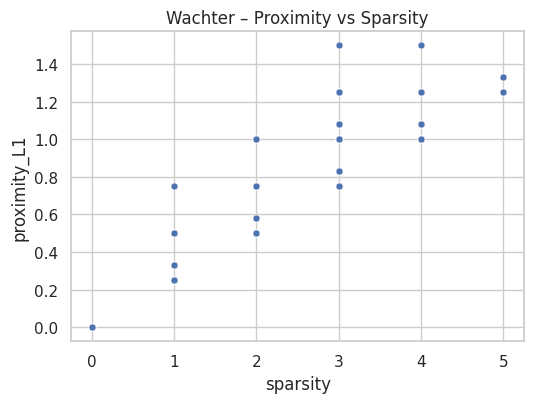

In [ ]:
# ===========================
# Wachter — Feature-level figures (match DiCE)
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, spearmanr

# ---- 0) Chuẩn bị CHANGES & EVAL nếu chưa có ----
# (Giả định đã có: CF_ALL (meta + features), X_batch (các base rows), feature_names)
assert 'CF_ALL' in globals(), "Cần CF_ALL từ pha sinh CF Wachter."
assert 'X_batch' in globals(), "Cần X_batch (các mẫu gốc tương ứng)."
assert 'feature_names' in globals(), "Cần feature_names (list tên cột)."

# Biên độ để chuẩn hóa L1
_ranges = {c: float(max(1e-9, Xtr[c].max() - Xtr[c].min())) for c in feature_names}

def _predict_label_np(xrow):
    return int(final_base_clf.predict(np.asarray(xrow).reshape(1, -1), validate_features=False)[0])

def _validity(cf_row):
    # hợp lệ nếu CF dự đoán là lớp 0 (not-at-risk) theo thiết kế global
    return 1 if _predict_label_np(cf_row) == 0 else 0

def _l1_proximity_norm(base_x, cf_x):
    diffs = np.abs(base_x.values - cf_x.values)
    norm  = np.array([_ranges[c] for c in feature_names], dtype=float)
    return float((diffs / norm).sum())

def _sparsity_L0(base_x, cf_x):
    return int(np.sum(~np.isclose(base_x.values, cf_x.values)))

# CHANGES (feature, delta)
change_rows = []
eval_rows = []
for i, r in CF_ALL.iterrows():
    qidx = r["_query_index"]
    if qidx not in X_batch.index:
        continue
    base_x = X_batch.loc[qidx, feature_names]
    cf_x   = r[feature_names]
    # EVAL
    eval_rows.append({
        "validity": _validity(cf_x),
        "proximity_L1": _l1_proximity_norm(base_x, cf_x),
        "sparsity": _sparsity_L0(base_x, cf_x),
    })
    # CHANGES
    deltas = (cf_x - base_x)
    mask   = ~np.isclose(deltas.values, 0.0)
    for col in np.array(feature_names)[mask]:
        change_rows.append({"feature": col, "delta": float(deltas[col])})

EVAL_W = pd.DataFrame(eval_rows)
CHANGES_W = pd.DataFrame(change_rows)

# ---- 1) Bảng Top features (giống DiCE) ----
if not CHANGES_W.empty:
    top_table_W = (
        CHANGES_W.groupby("feature").agg(
            n_changes=("delta", "count"),
            mean_abs_change=("delta", lambda x: float(np.mean(np.abs(x)))),
            pct_increase=("delta", lambda x: float(100.0*np.mean(np.array(x) > 0))),
            pct_decrease=("delta", lambda x: float(100.0*np.mean(np.array(x) < 0))),
        )
        .sort_values(["n_changes", "mean_abs_change"], ascending=False)
    )
    print("\nTop feature changes (Wachter):")
    print(top_table_W)

    # Bar chart Top-10 mean |Δ|
    top10 = top_table_W.sort_values("mean_abs_change", ascending=False).head(10).reset_index()
    plt.figure(figsize=(8, 4.2))
    sns.barplot(data=top10, x="feature", y="mean_abs_change")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("mean |Δ| (ordinal steps)")
    plt.title("Wachter – Mean |Δ| of Top-10 Most Changed Features")
    plt.tight_layout()
    plt.show()
else:
    print("\n(No feature changes recorded for Wachter.)")

# ---- 2) Phân phối sparsity & proximity, scatter (giống DiCE) ----
if not EVAL_W.empty:
    print(f'\nChi-square test across groups vs features: (bỏ qua ở bản feature-level)')
    rho, pval = spearmanr(EVAL_W["proximity_L1"], EVAL_W["sparsity"])
    print(f"Spearman(proximity_L1, sparsity) = {rho:.3f} (p={pval:.1e})")

    # Hist sparsity
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(EVAL_W["sparsity"], bins=10, kde=False)
    plt.title("Wachter – Distribution of Sparsity (#features changed)")
    plt.xlabel("sparsity")

    # Hist proximity
    plt.subplot(1, 2, 2)
    sns.histplot(EVAL_W["proximity_L1"], bins=10, kde=False)
    plt.title("Wachter – Distribution of Proximity (L1 normalized)")
    plt.xlabel("proximity_L1")

    plt.tight_layout()
    plt.show()

    # Scatter proximity vs sparsity
    plt.figure(figsize=(5.5, 4.2))
    sns.scatterplot(x=EVAL_W["sparsity"], y=EVAL_W["proximity_L1"], s=25)
    plt.title("Wachter – Proximity vs Sparsity")
    plt.xlabel("sparsity")
    plt.ylabel("proximity_L1")
    plt.tight_layout()
    plt.show()
else:
    print("\n(No EVAL records for Wachter.)")



# face

In [ ]:
# ===========================
# FACE-lite (Feasible & Actionable CFs) — Local + Global
# - Beam search theo bậc thang (±1 bước) trên các biến ordinal (số nguyên)
# - Actionability: quy định hướng thay đổi/đóng băng từng biến
# - Feasibility: phạt bằng kNN-density (gần phân bố train), chỉ nhận giá trị có trong train
# - Giữ format output giống DiCE/Wachter (LOCAL_ALL, CF_ALL, EVAL, CHANGES)
# ===========================
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import warnings

# (tắt cảnh báo tên cột LightGBM)
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMClassifier was fitted with feature names",
    category=UserWarning
)

# ---------- 0) CONFIG ----------
N_STUDENTS       = 50          # số học sinh trong batch global
TOTAL_CFS        = 3           # số CF mỗi học sinh
FREEZE_COLS      = ["Year_of_Study"]  # biến cố định
PERMITTED_RANGES = {
    # "Sleep_Hours": (0, 12),
    # "Stress_Levels": (0, 4),
}

# Hướng thay đổi (actionability):
#   "any": cho phép ±1
#   "up_only": chỉ +1
#   "down_only": chỉ -1
#   "fixed": cố định (giống FREEZE_COLS)
ACTIONABILITY = {
    # ví dụ: "Caffeine_Consumption": "down_only",
    #        "Physical_Activity": "up_only",
}
# Nếu không khai báo, mặc định "any" trừ FREEZE_COLS -> "fixed".

# Ngưỡng lật lớp
TARGET_PROBA = 0.80

# Hàm chi phí (chi phí càng nhỏ càng tốt)
LAMBDA_PROX   = 0.5   # L1 proximity (chuẩn hóa theo range)
GAMMA_FEAS    = 0.5   # kNN density penalty (feasibility)
KNN_K         = 15    # số hàng xóm để đo "độ hợp lý"
KNN_METRIC    = "euclidean"

# Beam search
MAX_STEPS     = 8     # số bước tối đa (Hamming distance tối đa)
BEAM_WIDTH    = 20    # giữ lại top ứng viên theo chi phí
DIVERSITY_W   = 0.10  # đẩy đa dạng (xa nhau theo L2 chuẩn hóa)

# LOCAL
RUN_LOCAL     = True
LOCAL_K       = 4

# GLOBAL
RUN_GLOBAL    = True

# ---------- 1) PREP ----------
feature_names = list(Xtr.columns)

# Lưu tập giá trị rời rạc từng cột (từ train) để bám sát tính ordinal
unique_vals = {c: np.sort(Xtr[c].dropna().unique().astype(int)) for c in feature_names}

# Range để chuẩn hóa L1
_ranges_vec = np.array([max(1e-9, Xtr[c].max() - Xtr[c].min()) for c in feature_names], dtype=float)
_range_map  = {c: float(max(1e-9, Xtr[c].max() - Xtr[c].min())) for c in feature_names}

# Bounds mỗi cột
def get_bounds(col):
    if col in PERMITTED_RANGES:
        lo, hi = PERMITTED_RANGES[col]
    else:
        lo, hi = float(Xtr[col].min()), float(Xtr[col].max())
    # ép về integer vì ordinal
    return int(np.floor(lo)), int(np.ceil(hi))

bounds_map = {c: get_bounds(c) for c in feature_names}

# Actionability map
def action_dir(col):
    if col in FREEZE_COLS:
        return "fixed"
    return ACTIONABILITY.get(col, "any")

# LightGBM-safe predict_proba / predict
def _predict_proba_np(model, x_np):
    if isinstance(x_np, pd.Series):
        x_np = x_np.values
    if x_np.ndim == 1:
        x_np = x_np.reshape(1, -1)
    return model.predict_proba(x_np, validate_features=False)

def _predict_label_np(model, x_np):
    return int(np.argmax(_predict_proba_np(model, x_np)[0]))

# kNN fit trên train để tính “feasibility”
# (Chuẩn hóa theo min-max để tránh scale bias)
_Xtr_min = Xtr.min().values
_Xtr_rng = np.maximum(1e-9, (Xtr.max() - Xtr.min()).values)
Xtr_scaled = (Xtr.values - _Xtr_min) / _Xtr_rng
_knn = NearestNeighbors(n_neighbors=KNN_K, metric=KNN_METRIC)
_knn.fit(Xtr_scaled)

def knn_density_penalty(x):
    # x: vector (d,), chuẩn hóa và lấy khoảng cách trung bình đến K láng giềng
    xs = ((x - _Xtr_min) / _Xtr_rng).reshape(1, -1)
    dists, _ = _knn.kneighbors(xs, n_neighbors=KNN_K, return_distance=True)
    return float(dists.mean())  # càng nhỏ càng "hợp lý" => penalty = mean_dist

# L1 proximity chuẩn hóa
def prox_l1(x, x0):
    diffs = np.abs(x - x0)
    return float((diffs / _ranges_vec).sum())

# Diversity penalty so với các CF đã có (đơn giản, L2 chuẩn hóa)
def diversity_pen(x, existing):
    if not existing:
        return 0.0
    x = np.asarray(x, dtype=float)
    pen = 0.0
    for prev in existing:
        d = np.linalg.norm((x - prev) / _ranges_vec)
        pen += np.exp(-d)  # gần -> penalty lớn
    return DIVERSITY_W * pen

# Giá trị “bật/tắt” theo actionability cho từng biến
def neighbor_values_for_col(col, cur_val):
    if action_dir(col) == "fixed":
        return [cur_val]
    lo, hi = bounds_map[col]
    vals = unique_vals[col]
    # Bước nhảy ±1 trên trục ordinal nhưng ràng buộc vào tập giá trị hợp lệ của train
    vset = set(vals.tolist())
    cand = []
    if action_dir(col) in ("any", "down_only"):
        if (cur_val - 1) in vset and cur_val - 1 >= lo:
            cand.append(cur_val - 1)
    if action_dir(col) in ("any", "up_only"):
        if (cur_val + 1) in vset and cur_val + 1 <= hi:
            cand.append(cur_val + 1)
    # nếu không có hàng xóm (do train không chứa), giữ nguyên
    return cand if cand else [cur_val]

# Sinh lân cận bằng cách thay đổi MỘT biến mỗi lần (Hamming=1)
def generate_neighbors(x_vec):
    neighbors = []
    for i, col in enumerate(feature_names):
        cur = int(x_vec[i])
        for v in neighbor_values_for_col(col, cur):
            if v != cur:
                newx = x_vec.copy()
                newx[i] = v
                neighbors.append(newx)
    return neighbors

# Chi phí tổng hợp (càng nhỏ càng tốt)
def total_cost(x, x0, model, desired_class, cfs_found):
    p_des = _predict_proba_np(model, np.asarray(x))[0, int(desired_class)]
    cls_hinge = max(0.0, TARGET_PROBA - float(p_des))**2
    return cls_hinge + LAMBDA_PROX * prox_l1(x, x0) + GAMMA_FEAS * knn_density_penalty(x) + diversity_pen(x, cfs_found)

# Beam search cho 1 cá thể
def face_beam_search_instance(query_instance: pd.Series,
                              model,
                              desired_label: int,
                              total_cfs: int):
    """
    Trả về: np.ndarray shape (n_cf, d) với giá trị số nguyên.
    """
    x0 = query_instance.values.astype(int)
    # Khởi tạo
    frontier = [x0]
    visited = set()
    cfs = []

    def key_of(x):
        return tuple(map(int, x))

    # Nếu ngay từ đầu đã đạt proba target (hiếm), bỏ qua
    if _predict_proba_np(model, x0)[0, desired_label] >= TARGET_PROBA:
        cfs.append(x0.copy())

    for step in range(1, MAX_STEPS + 1):
        # Sinh toàn bộ hàng xóm bậc 1 từ các ứng viên trong frontier
        candidates = []
        for state in frontier:
            for nb in generate_neighbors(state):
                k = key_of(nb)
                if k in visited:
                    continue
                visited.add(k)
                candidates.append(nb)

        if not candidates:
            break

        # Tính chi phí và sort, lấy top BEAM_WIDTH
        scored = []
        for cand in candidates:
            cost = total_cost(cand, x0, model, desired_label, cfs)
            scored.append((cost, cand))
        scored.sort(key=lambda z: z[0])
        frontier = [cand for (_, cand) in scored[:BEAM_WIDTH]]

        # Thu hoạch CF đạt proba
        for cand in frontier:
            if _predict_proba_np(model, cand)[0, desired_label] >= TARGET_PROBA:
                # Không thêm trùng
                if not any(np.all(cand == cf) for cf in cfs):
                    cfs.append(cand.copy())
            if len(cfs) >= total_cfs:
                break
        if len(cfs) >= total_cfs:
            break

    # Nếu chưa đủ CF, vẫn trả về những cái tốt nhất trên frontier (để không rỗng)
    if len(cfs) < total_cfs and frontier:
        need = total_cfs - len(cfs)
        for cand in frontier[:need]:
            if not any(np.all(cand == cf) for cf in cfs):
                cfs.append(cand.copy())

    if len(cfs) == 0:
        return np.empty((0, len(feature_names)), dtype=int)
    return np.vstack(cfs)

# Wrapper tạo nhiều CF (giống DiCE)
def generate_face_cfs_for_instance(query_instance: pd.Series,
                                   model,
                                   desired_label: int,
                                   total_cfs: int):
    return face_beam_search_instance(query_instance, model, desired_label, total_cfs)

# ---------- 2) LOCAL ----------
LOCAL_ALL = pd.DataFrame()
if RUN_LOCAL:
    x_query_local = Xte.iloc[:LOCAL_K].copy()
    local_cf_rows, local_meta = [], []
    for ridx, (_, row) in enumerate(x_query_local.iterrows()):
        base_pred = _predict_label_np(final_base_clf, row.values)
        desired   = 1 - base_pred  # opposite
        cfs = generate_face_cfs_for_instance(row, final_base_clf, desired_label=desired, total_cfs=TOTAL_CFS)
        for j in range(cfs.shape[0]):
            local_cf_rows.append(cfs[j, :])
            local_meta.append({"_query_row": ridx, "_orig_pred": base_pred})

    LOCAL_CF = pd.DataFrame(local_cf_rows, columns=feature_names) if local_cf_rows else pd.DataFrame(columns=feature_names)
    LOCAL_META = pd.DataFrame(local_meta)
    LOCAL_ALL = pd.concat([LOCAL_META, LOCAL_CF], axis=1) if not LOCAL_CF.empty else LOCAL_META.copy()

    print("\n=== Local CFs (first 4 students, show only changes) ===")
    if not LOCAL_ALL.empty:
        for ridx in LOCAL_ALL["_query_row"].unique():
            base_x = x_query_local.iloc[int(ridx)][feature_names].astype(int)
            cf_rows = LOCAL_ALL[LOCAL_ALL["_query_row"] == ridx][feature_names].astype(int)
            for j, (_, cf_row) in enumerate(cf_rows.iterrows()):
                changed = {c: (int(base_x[c]), int(cf_row[c]))
                           for c in feature_names if base_x[c] != cf_row[c]}
                print(f"[row {ridx}] CF#{j+1}: {changed}")
    else:
        print("(No LOCAL CFs generated.)")

# ---------- 3) GLOBAL ----------
CF_ALL = pd.DataFrame()
if RUN_GLOBAL:
    scores_te = _predict_proba_np(final_base_clf, Xte.values)[:, 1]
    preds_te  = final_base_clf.predict(Xte.values, validate_features=False)

    cand_idx = Xte.index[preds_te == 1]
    idx_list = cand_idx[:N_STUDENTS].tolist()

    X_batch = Xte.loc[idx_list].copy()
    cf_rows, meta_rows = [], []
    for q_idx in idx_list:
        base_pred  = int(preds_te[Xte.index.get_loc(q_idx)])
        base_score = float(scores_te[Xte.index.get_loc(q_idx)])
        cfs = generate_face_cfs_for_instance(
            X_batch.loc[q_idx], final_base_clf, desired_label=0, total_cfs=TOTAL_CFS
        )
        for j in range(cfs.shape[0]):
            cf_rows.append(cfs[j, :])
            meta_rows.append({"_query_index": q_idx, "_orig_pred": base_pred, "_orig_score": base_score})

    CF_FACE = pd.DataFrame(cf_rows, columns=feature_names).astype(int) if cf_rows else pd.DataFrame(columns=feature_names)
    META = pd.DataFrame(meta_rows)
    CF_ALL = pd.concat([META, CF_FACE], axis=1) if not CF_FACE.empty else META.copy()

    print("\nCF_ALL (first 10 rows):")
    print(CF_ALL.head(10))

# ---------- 4) EVALUATION ----------
def predict_label_row(xrow):
    return int(final_base_clf.predict(np.asarray(xrow).reshape(1, -1), validate_features=False)[0])

def validity(cf_row):
    return 1 if predict_label_row(cf_row) == 0 else 0

def l1_proximity_norm(base_x, cf_x):
    diffs = np.abs(base_x.values - cf_x.values)
    norm  = np.array([_range_map[c] for c in feature_names], dtype=float)
    return float((diffs / norm).sum())

def sparsity_L0(base_x, cf_x):
    return int(np.sum(base_x.values != cf_x.values))

EVAL = pd.DataFrame()
CHANGES = pd.DataFrame()
if not CF_ALL.empty:
    # Build X_batch cho các chỉ số đã sinh CF
    used_idx = CF_ALL["_query_index"].unique() if "_query_index" in CF_ALL.columns else []
    X_batch_used = Xte.loc[used_idx, feature_names].astype(int) if len(used_idx) else pd.DataFrame(columns=feature_names)

    # EVAL
    eval_rows = []
    for i, r in CF_ALL.iterrows():
        qidx  = r["_query_index"]
        if qidx not in X_batch_used.index:
            continue
        base_x = X_batch_used.loc[qidx, feature_names]
        cf_x   = r[feature_names].astype(int)
        eval_rows.append({
            "validity": validity(cf_x),
            "proximity_L1": l1_proximity_norm(base_x, cf_x),
            "sparsity": sparsity_L0(base_x, cf_x)
        })
    EVAL = pd.DataFrame(eval_rows)
    print("\n=== FACE-lite CF evaluation (validity / proximity_L1 / sparsity) ===")
    print(EVAL.describe() if not EVAL.empty else "(no CFs to evaluate)")

    # CHANGES
    change_records = []
    for i, r in CF_ALL.iterrows():
        qidx  = r["_query_index"]
        if qidx not in X_batch_used.index:
            continue
        base_x = X_batch_used.loc[qidx, feature_names]
        cf_x   = r[feature_names].astype(int)
        diff_mask = (base_x.values != cf_x.values)
        changed_cols = np.array(feature_names)[diff_mask]
        for col in changed_cols:
            delta = int(cf_x[col] - base_x[col])
            change_records.append({"feature": col, "delta": delta})
    CHANGES = pd.DataFrame(change_records)

# Sau khi chạy, bạn sẽ có:
# - LOCAL_ALL: CF local
# - CF_ALL: CF global
# - EVAL: validity / proximity / sparsity
# - CHANGES: bảng thay đổi (feature, delta)



=== Local CFs (first 4 students, show only changes) ===
[row 0] CF#1: {'Difficulty_Falling_Asleep': (2, 3), 'Sleep_Quality': (4, 2), 'Daytime_Fatigue': (4, 3), 'Impact_on_Deadlines': (4, 3), 'Physical_Activity': (4, 3)}
[row 0] CF#2: {'Difficulty_Falling_Asleep': (2, 3), 'Sleep_Quality': (4, 2), 'Concentration_Problems': (2, 3), 'Daytime_Fatigue': (4, 3), 'Impact_on_Deadlines': (4, 3), 'Physical_Activity': (4, 3)}
[row 0] CF#3: {'Difficulty_Falling_Asleep': (2, 3), 'Wakeup_Difficulty': (4, 3), 'Sleep_Quality': (4, 2), 'Daytime_Fatigue': (4, 3), 'Impact_on_Deadlines': (4, 3), 'Physical_Activity': (4, 3)}
[row 1] CF#1: {'Wakeup_Difficulty': (2, 3), 'Daytime_Fatigue': (4, 1), 'Physical_Activity': (3, 4)}
[row 1] CF#2: {'Wakeup_Difficulty': (2, 3), 'Sleep_Quality': (0, 1), 'Daytime_Fatigue': (4, 3), 'Caffeine_Consumption': (3, 1)}
[row 1] CF#3: {'Sleep_Hours': (3, 4), 'Wakeup_Difficulty': (2, 3), 'Daytime_Fatigue': (4, 3), 'Missed_Classes': (3, 4), 'Caffeine_Consumption': (3, 4), 'Physica

## diagram

group
sleep        192
academic     145
lifestyle    123
stress        79
Name: feature, dtype: int64
Chi-square = 1617.0 p = 0.0


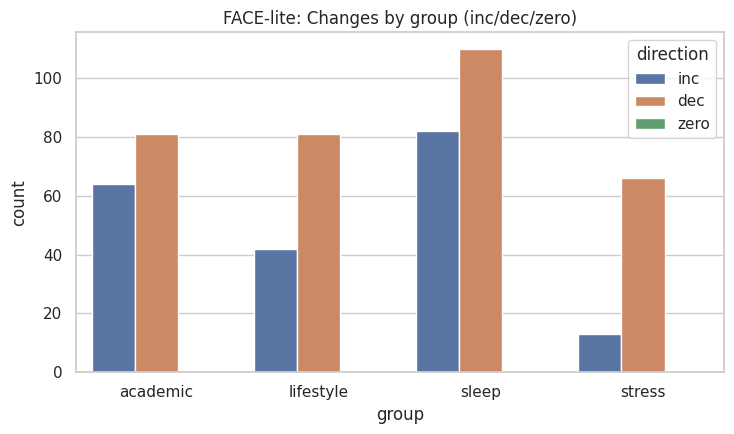

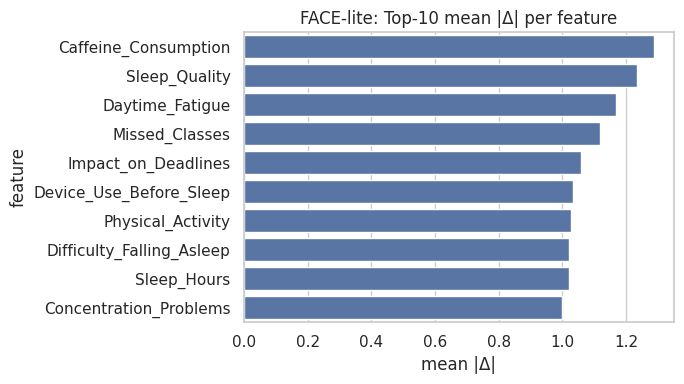

Spearman (proximity_L1 vs sparsity): 0.9504492639645222 p = 5.514552281617693e-77


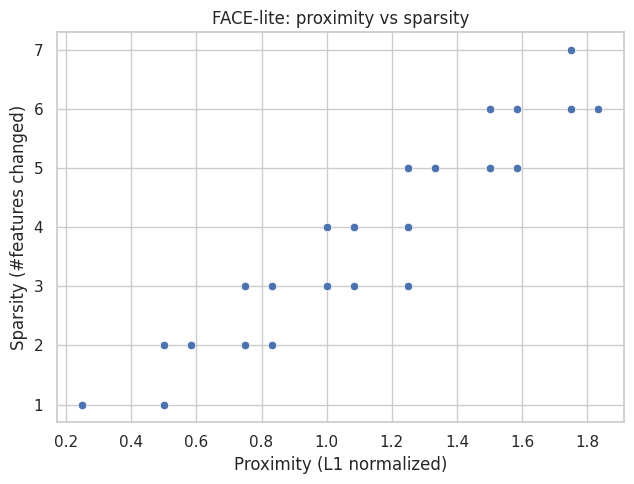

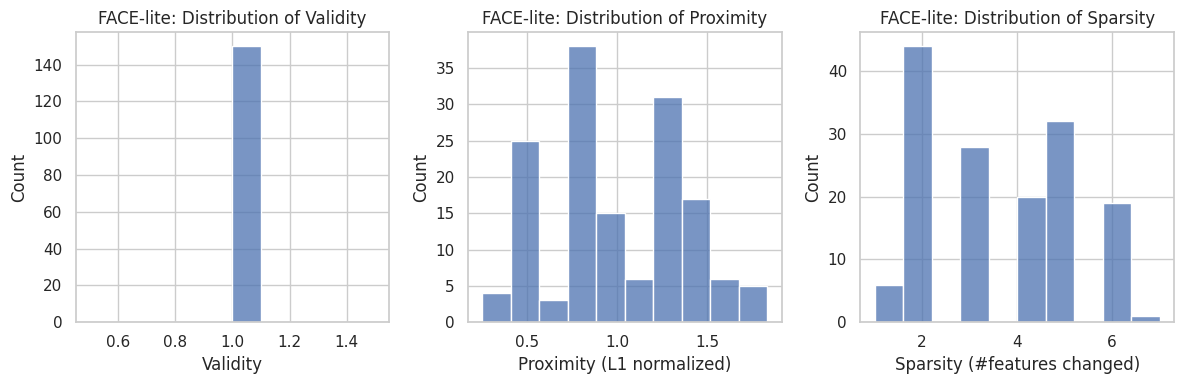

In [ ]:
# ===========================
# Visualization for FACE-lite (same style as DiCE)
# Requires:
#   - EVAL  (validity, proximity_L1, sparsity)
#   - CHANGES (feature, delta)
# ===========================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, spearmanr

# 1) Gom nhóm feature như trước
feature_groups = {
    "sleep": ["Sleep_Hours", "Sleep_Quality", "Difficulty_Falling_Asleep", "Wakeup_Difficulty"],
    "stress": ["Stress_Levels", "Daytime_Fatigue"],
    "lifestyle": ["Device_Use_Before_Sleep", "Caffeine_Consumption", "Physical_Activity"],
    "academic": ["Concentration_Problems", "Missed_Classes", "Impact_on_Deadlines"]
}
def map_group(f):
    for g, feats in feature_groups.items():
        if f in feats:
            return g
    return "other"

if not CHANGES.empty:
    CHANGES["group"] = CHANGES["feature"].map(map_group)

    # (A) Đếm số thay đổi theo group
    group_counts = CHANGES.groupby("group")["feature"].count().sort_values(ascending=False)
    print(group_counts)

    # (B) Kiểm định chi-square: phân phối thay đổi theo feature trong từng group
    cont_table = pd.crosstab(CHANGES["group"], CHANGES["feature"])
    if cont_table.shape[0] > 1 and cont_table.shape[1] > 1:
        chi2, p, dof, expected = chi2_contingency(cont_table)
        print("Chi-square =", chi2, "p =", p)

    # (C) Phân rã hướng thay đổi theo group
    chg_dir = CHANGES.assign(
        inc=(CHANGES["delta"] > 0).astype(int),
        dec=(CHANGES["delta"] < 0).astype(int),
        zero=(CHANGES["delta"] == 0).astype(int),
    ).groupby("group")[["inc","dec","zero"]].sum()
    plot_df = chg_dir.reset_index().melt(id_vars="group", value_vars=["inc","dec","zero"],
                                         var_name="direction", value_name="count")

    plt.figure(figsize=(7.5, 4.5))
    sns.barplot(data=plot_df, x="group", y="count", hue="direction")
    plt.title("FACE-lite: Changes by group (inc/dec/zero)")
    plt.tight_layout()
    plt.show()

    # (D) Top-10 feature có |delta| trung bình lớn nhất
    top10 = (CHANGES.assign(abs_delta=lambda d: d["delta"].abs())
                    .groupby("feature")["abs_delta"].mean()
                    .sort_values(ascending=False).head(10))
    plt.figure(figsize=(7, 4))
    sns.barplot(x=top10.values, y=top10.index, orient="h")
    plt.title("FACE-lite: Top-10 mean |Δ| per feature")
    plt.xlabel("mean |Δ|")
    plt.tight_layout()
    plt.show()

# (E) Tương quan proximity vs sparsity
if not EVAL.empty:
    rho, pval = spearmanr(EVAL["proximity_L1"], EVAL["sparsity"])
    print("Spearman (proximity_L1 vs sparsity):", rho, "p =", pval)

    plt.figure(figsize=(6.5, 5))
    sns.scatterplot(x=EVAL["proximity_L1"], y=EVAL["sparsity"])
    plt.title("FACE-lite: proximity vs sparsity")
    plt.xlabel("Proximity (L1 normalized)")
    plt.ylabel("Sparsity (#features changed)")
    plt.tight_layout()
    plt.show()

    # (F) Phân phối validity / proximity / sparsity
    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1); sns.histplot(EVAL["validity"], bins=10, kde=False)
    plt.title("FACE-lite: Distribution of Validity")
    plt.xlabel("Validity")

    plt.subplot(1,3,2); sns.histplot(EVAL["proximity_L1"], bins=10, kde=False)
    plt.title("FACE-lite: Distribution of Proximity")
    plt.xlabel("Proximity (L1 normalized)")

    plt.subplot(1,3,3); sns.histplot(EVAL["sparsity"], bins=10, kde=False)
    plt.title("FACE-lite: Distribution of Sparsity")
    plt.xlabel("Sparsity (#features changed)")

    plt.tight_layout()
    plt.show()